In [1]:
from ProcessDataFunctions import datTXT_to_DF
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
import mplhep as hep
import pandas as pd
import pickle

In [2]:
data_DF = datTXT_to_DF("/Users/seanbp/Documents/Data/GenII_Prototype_Data/BNL/Run165_list.txt")

In [3]:
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def plot_caen_histograms(dataframe, caen_unit, Peds, PedStds, PedErrs, PedStdErrs, gain_type="LG"):
    fig, axes = plt.subplots(8, 8, figsize=(20, 20), sharex=True, sharey=True)
    fig.suptitle(f"CAEN {caen_unit} - {gain_type}", fontsize=20, y=1.02)

    if gain_type == "HG":
        max_val = 2000
        num_bins = 200
    elif gain_type == "LG":
        max_val = 400
        num_bins = 200
    else:
        raise ValueError("gain_type must be 'HG' or 'LG'")

    for ch in range(64):
        ax = axes[ch // 8, ch % 8]
        df_ch = dataframe[(dataframe["CAEN"] == caen_unit) & (dataframe["CAEN_ch"] == ch)]
        if df_ch.empty:
            ax.set_title(f"Ch {ch}")
            continue

        raw_data = df_ch[gain_type].to_numpy()
        filtered_data = raw_data[(raw_data > 0) & (raw_data < max_val)]
        if len(filtered_data) < 10:
            ax.set_title(f"Ch {ch} (no data)")
            continue

        counts, bin_edges = np.histogram(filtered_data, bins=num_bins, range=(0, max_val))
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        y_errors = np.sqrt(counts)
        mask = (counts > 0) & (counts < 5000)

        x_data = bin_centers[mask]
        y_data = counts[mask]
        fit_errors = y_errors[mask]

        if len(x_data) < 3:
            ax.set_title(f"Ch {ch} (insufficient)")
            continue

        initial_params = [
            max(y_data),
            np.mean(filtered_data),
            np.std(filtered_data)
        ]

        least_squares = LeastSquares(x_data, y_data, fit_errors, gauss)
        m = Minuit(least_squares, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
        m.limits["sigma"] = (0, None)
        m.migrad()

        fit_vals = m.values
        fit_errs = m.errors
        A_fit, mu_fit, sigma_fit = fit_vals["A"], fit_vals["mu"], fit_vals["sigma"]
        fit_x = np.linspace(0, max_val, 1500)
        fit_y = gauss(fit_x, A_fit, mu_fit, sigma_fit)
    
        ax.errorbar(x_data, y_data, yerr=fit_errors, fmt='o', markersize=3, label=f"Ch {ch}")
        ax.plot(fit_x, fit_y, color='tab:orange')
        #ax.set_title(f"Ch {ch}")
        ax.set_xlim(0, max_val)
        ax.legend()
        
        Peds.append(mu_fit)
        PedStds.append(sigma_fit)
        PedErrs.append(fit_errs['mu'])
        PedStdErrs.append(fit_errs['sigma'])


    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


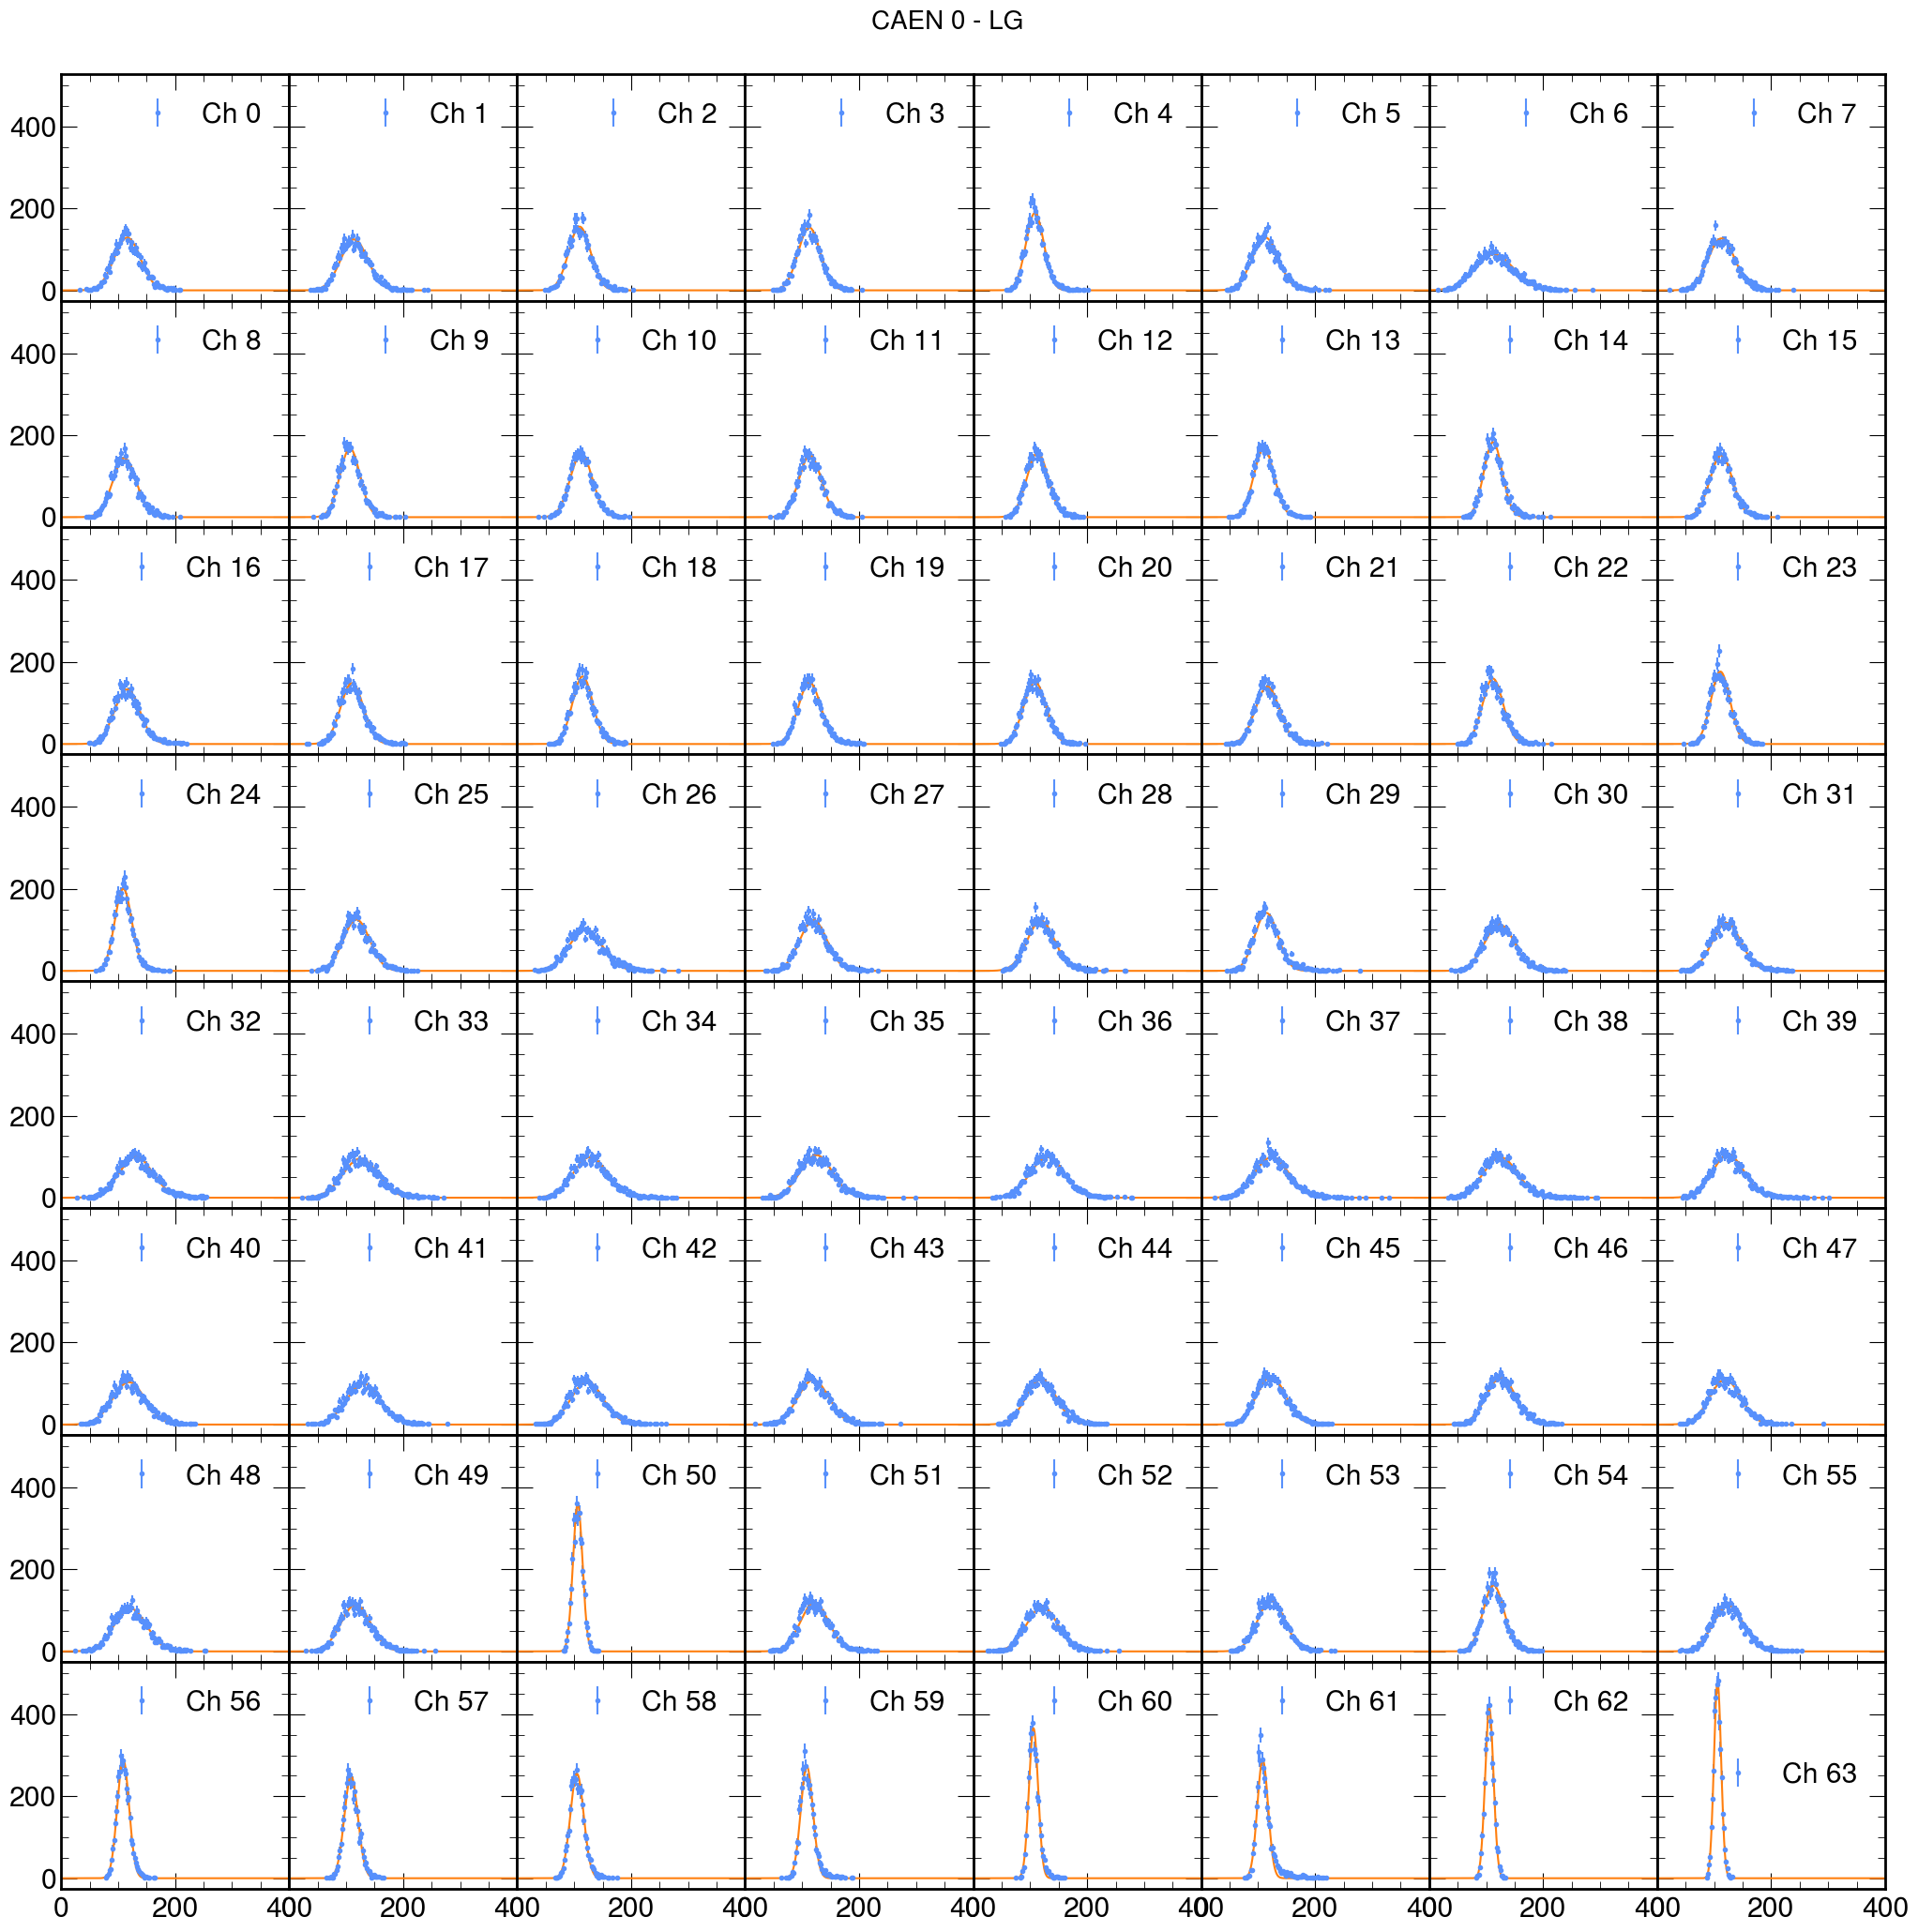

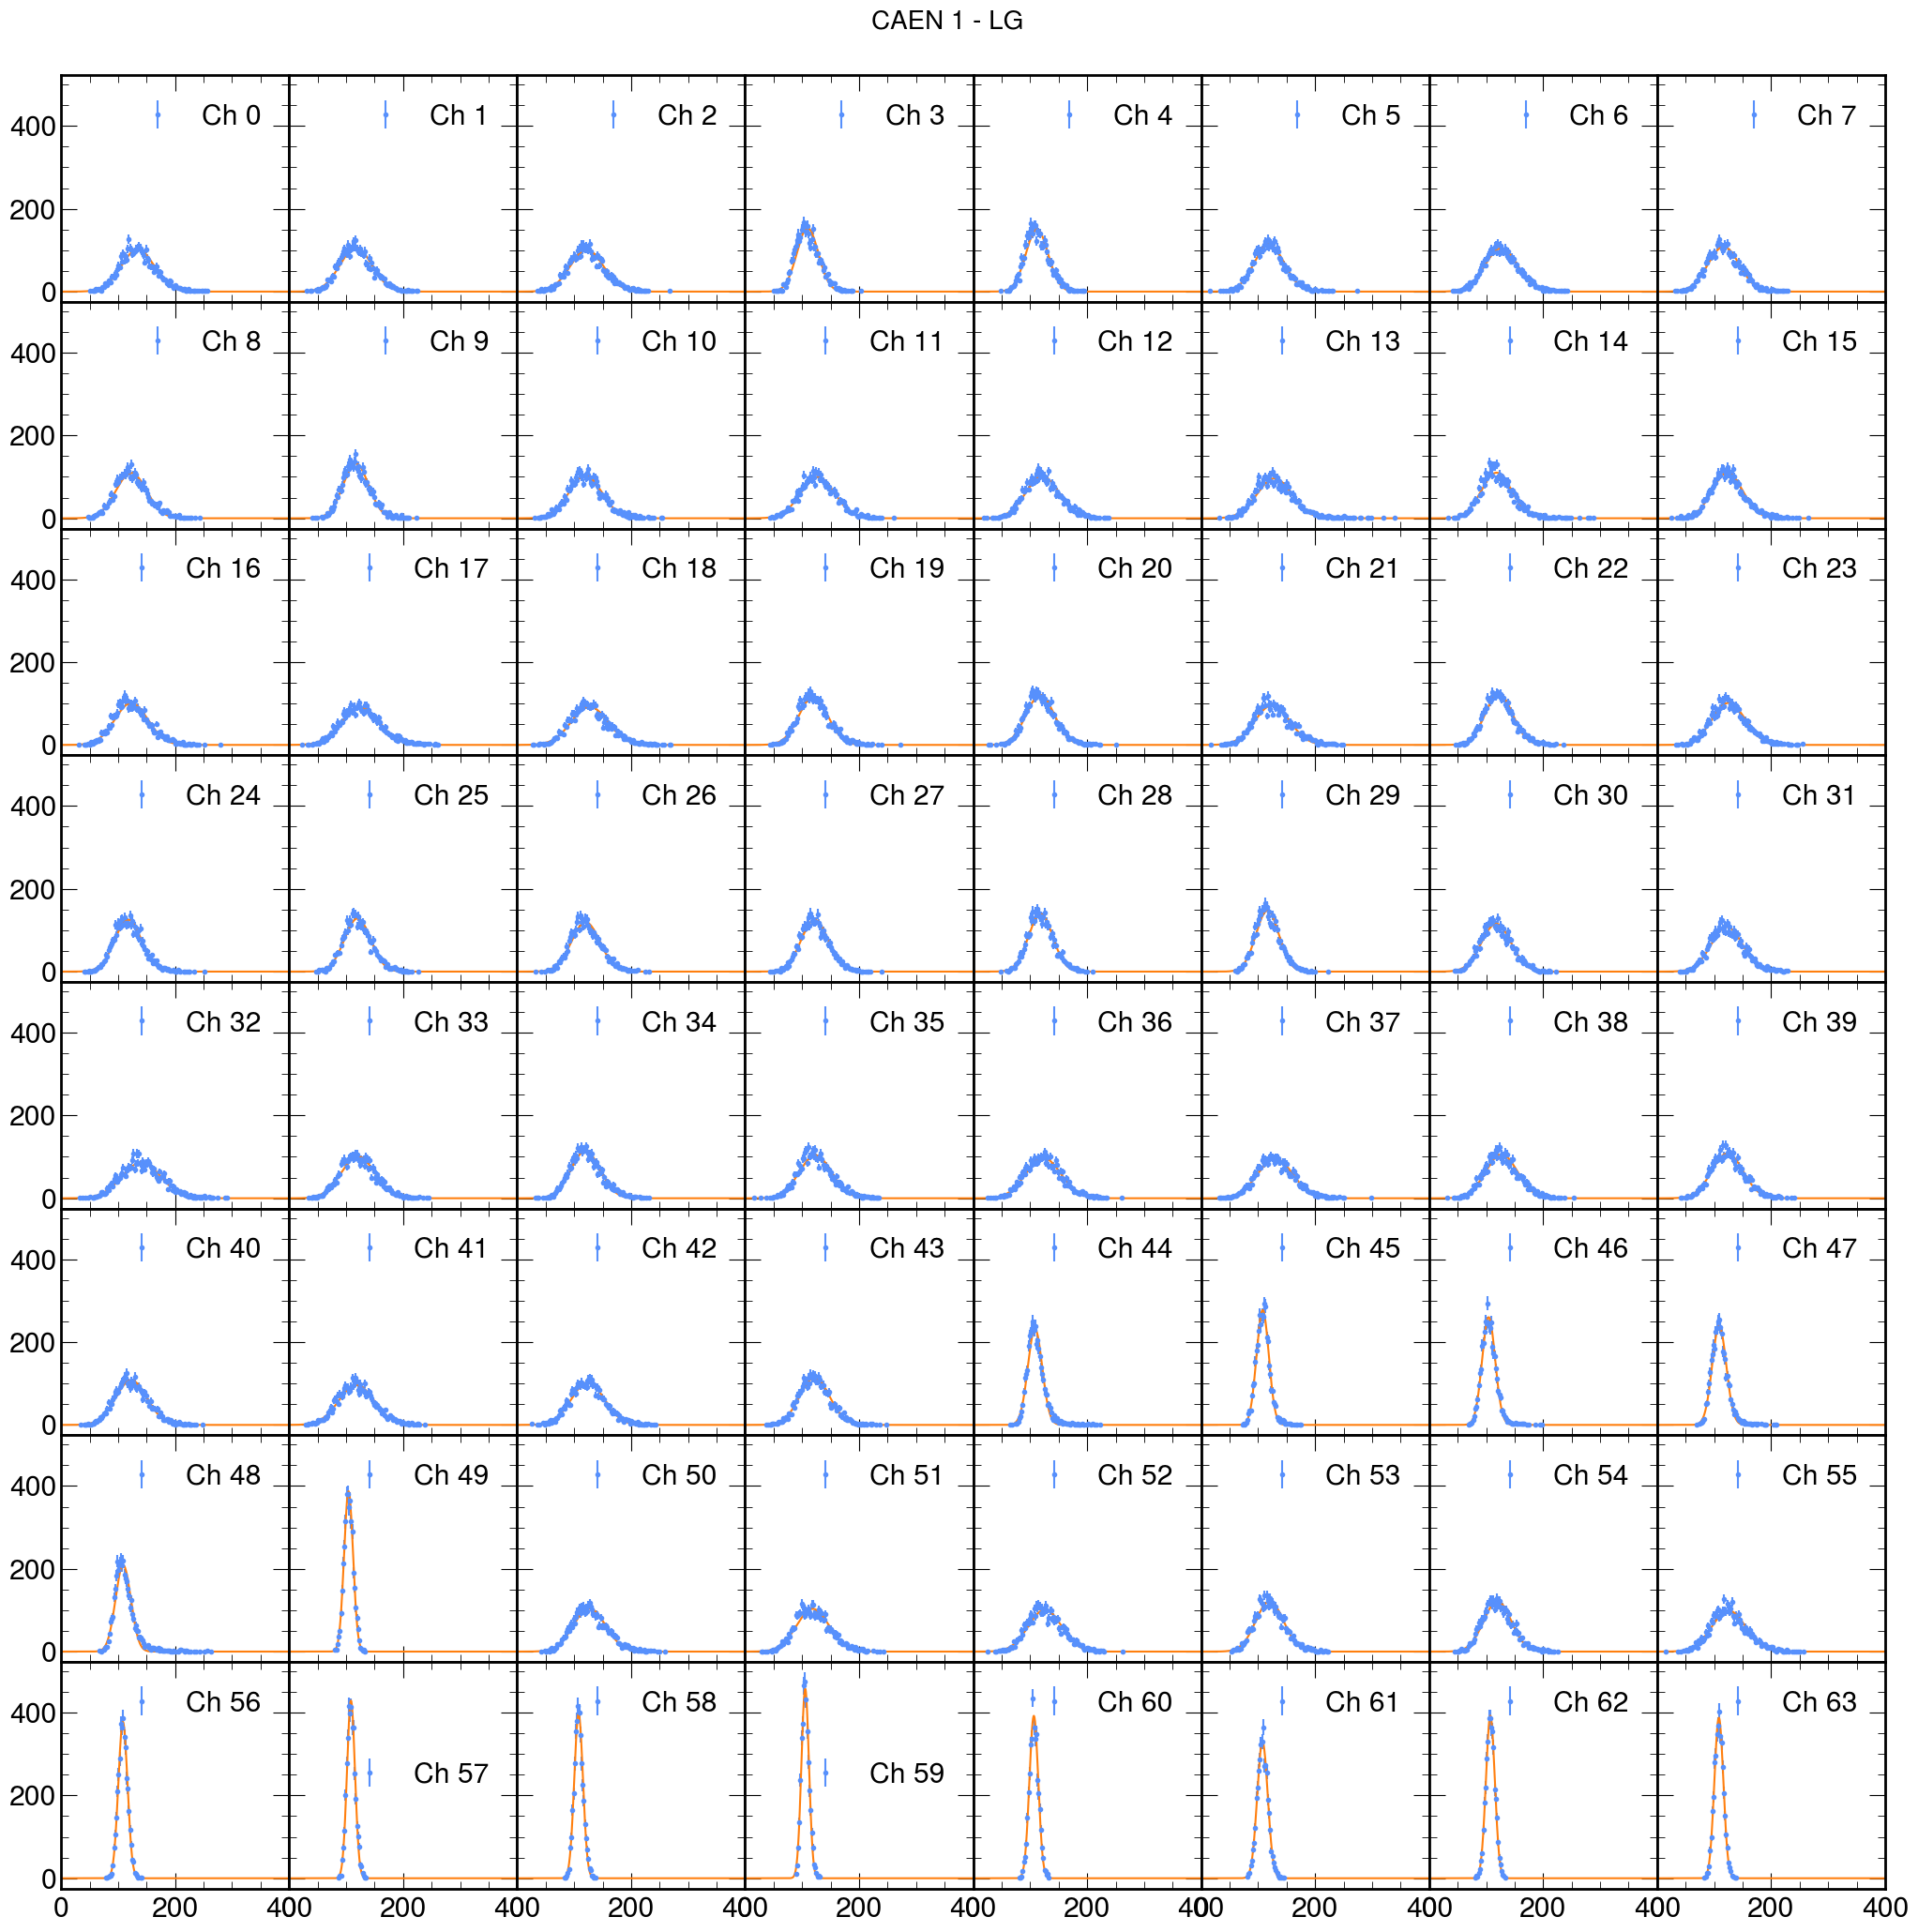

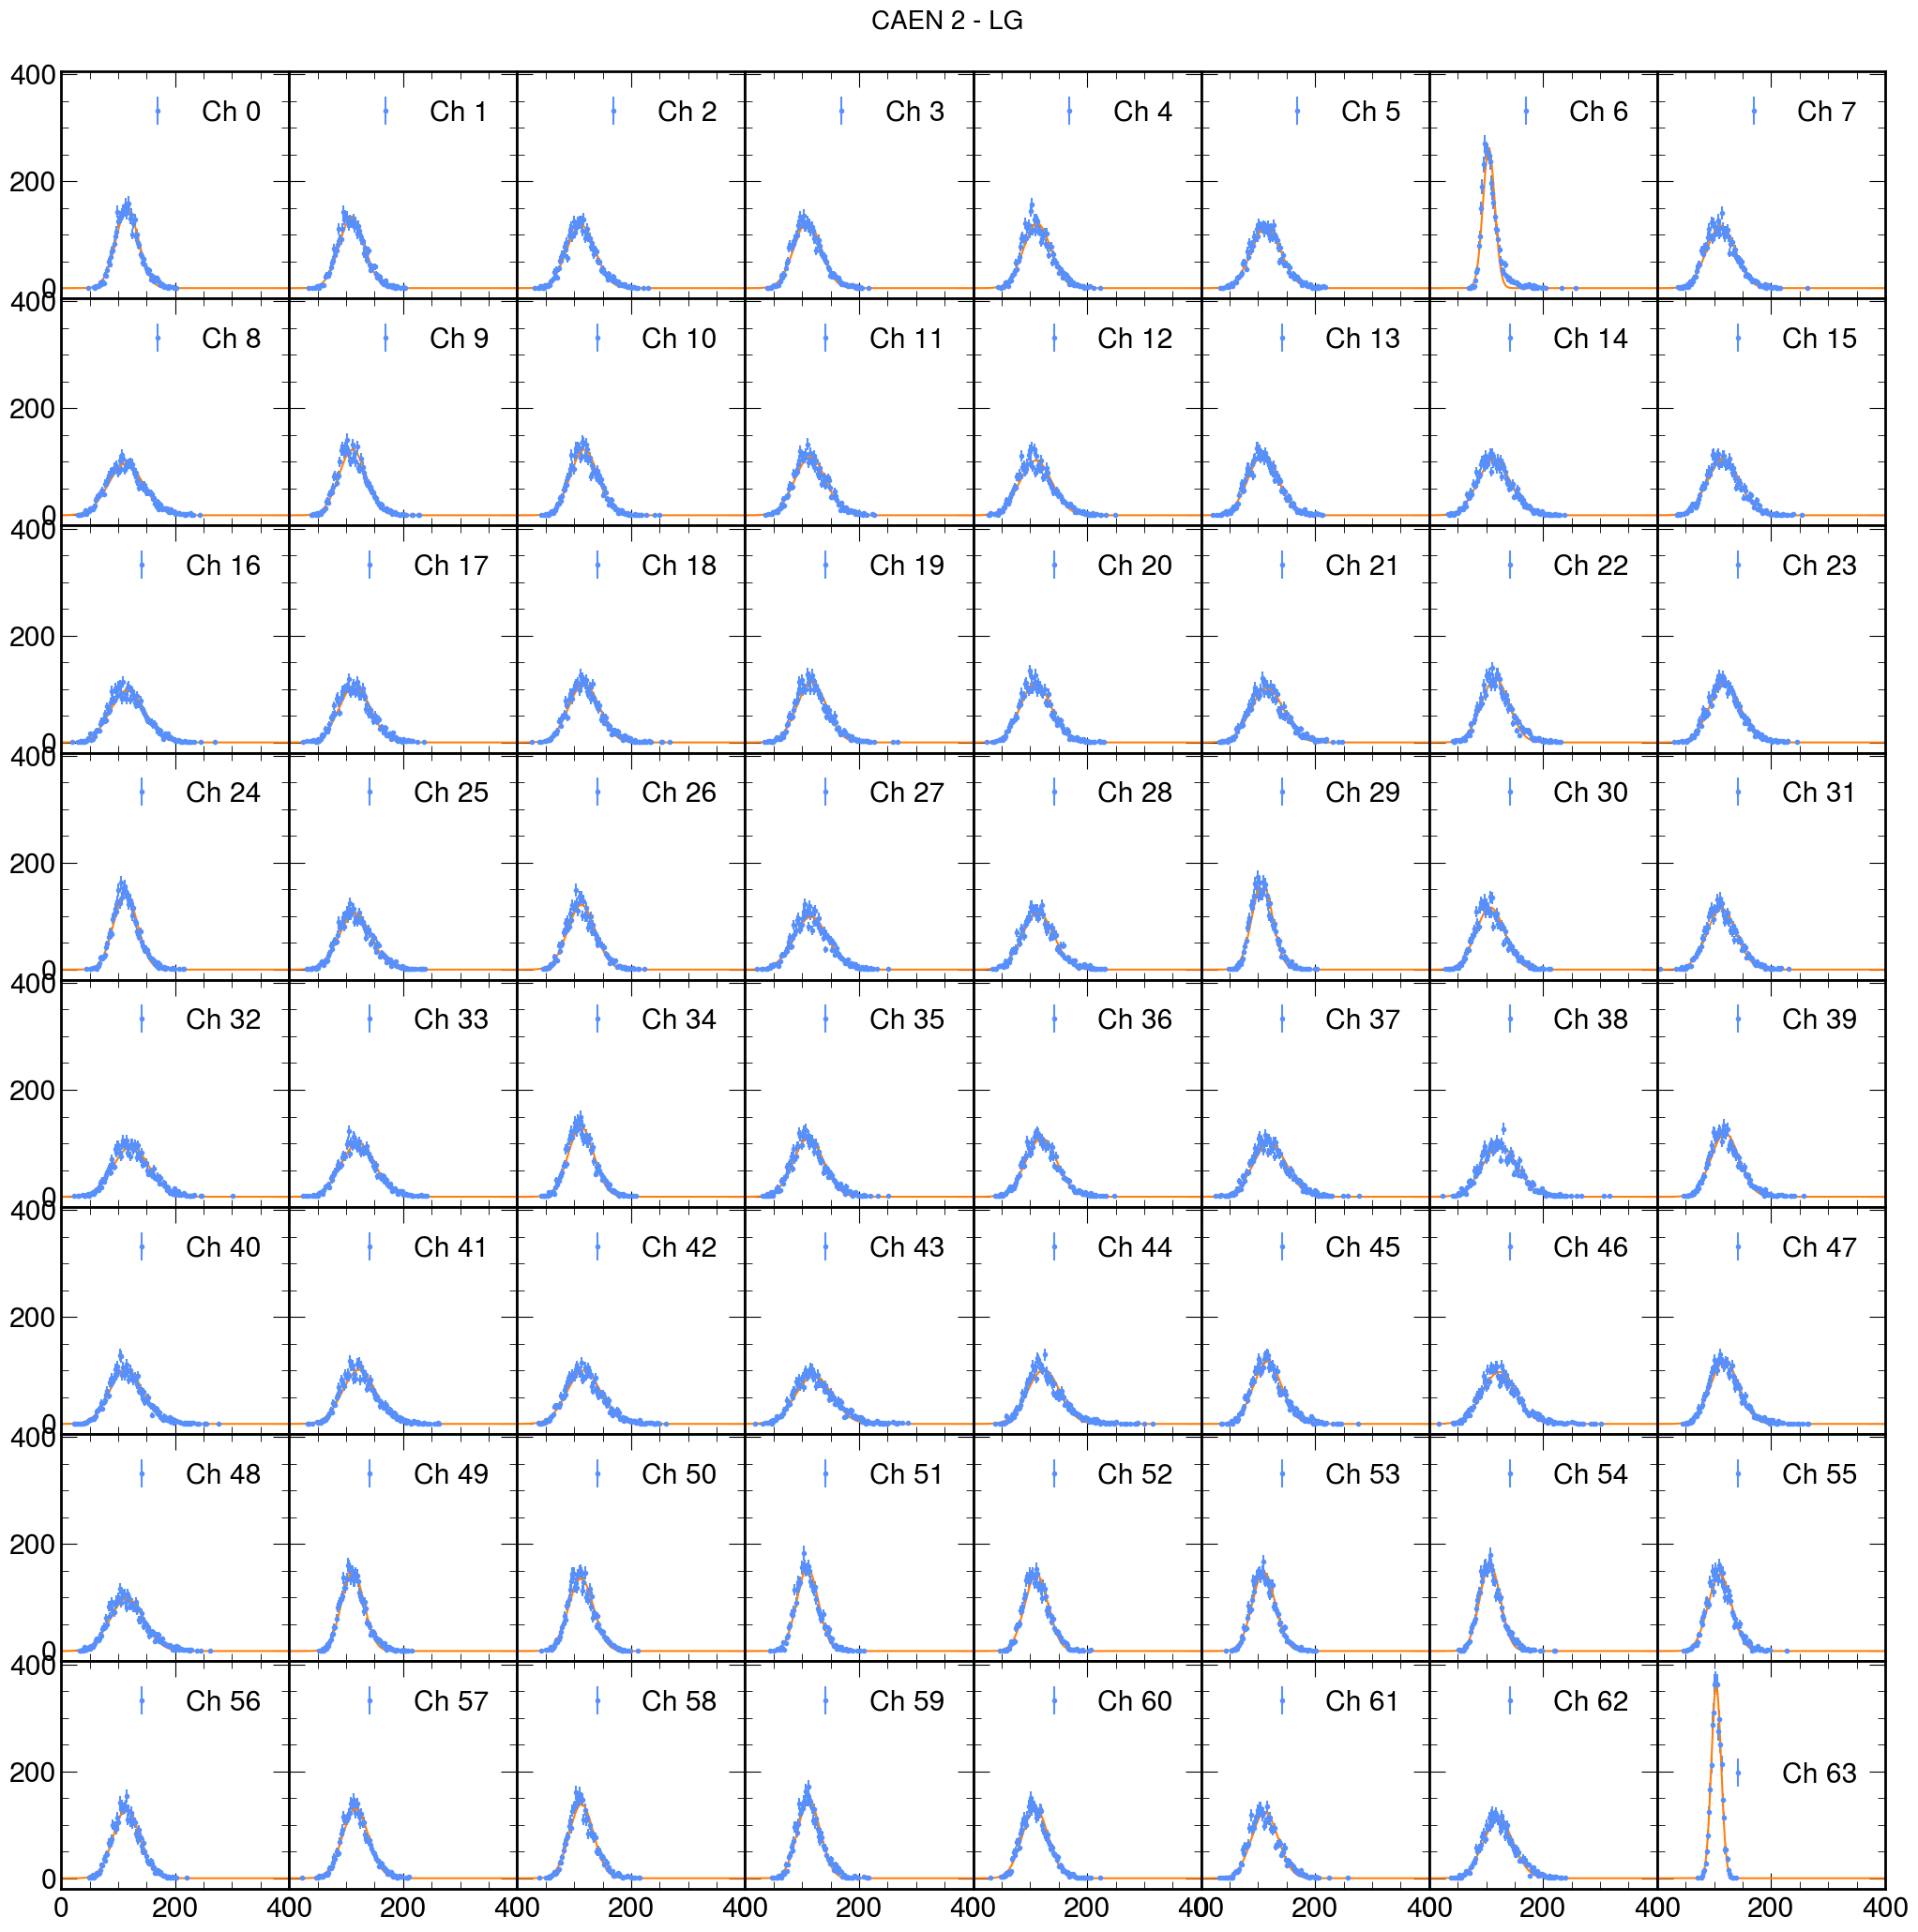

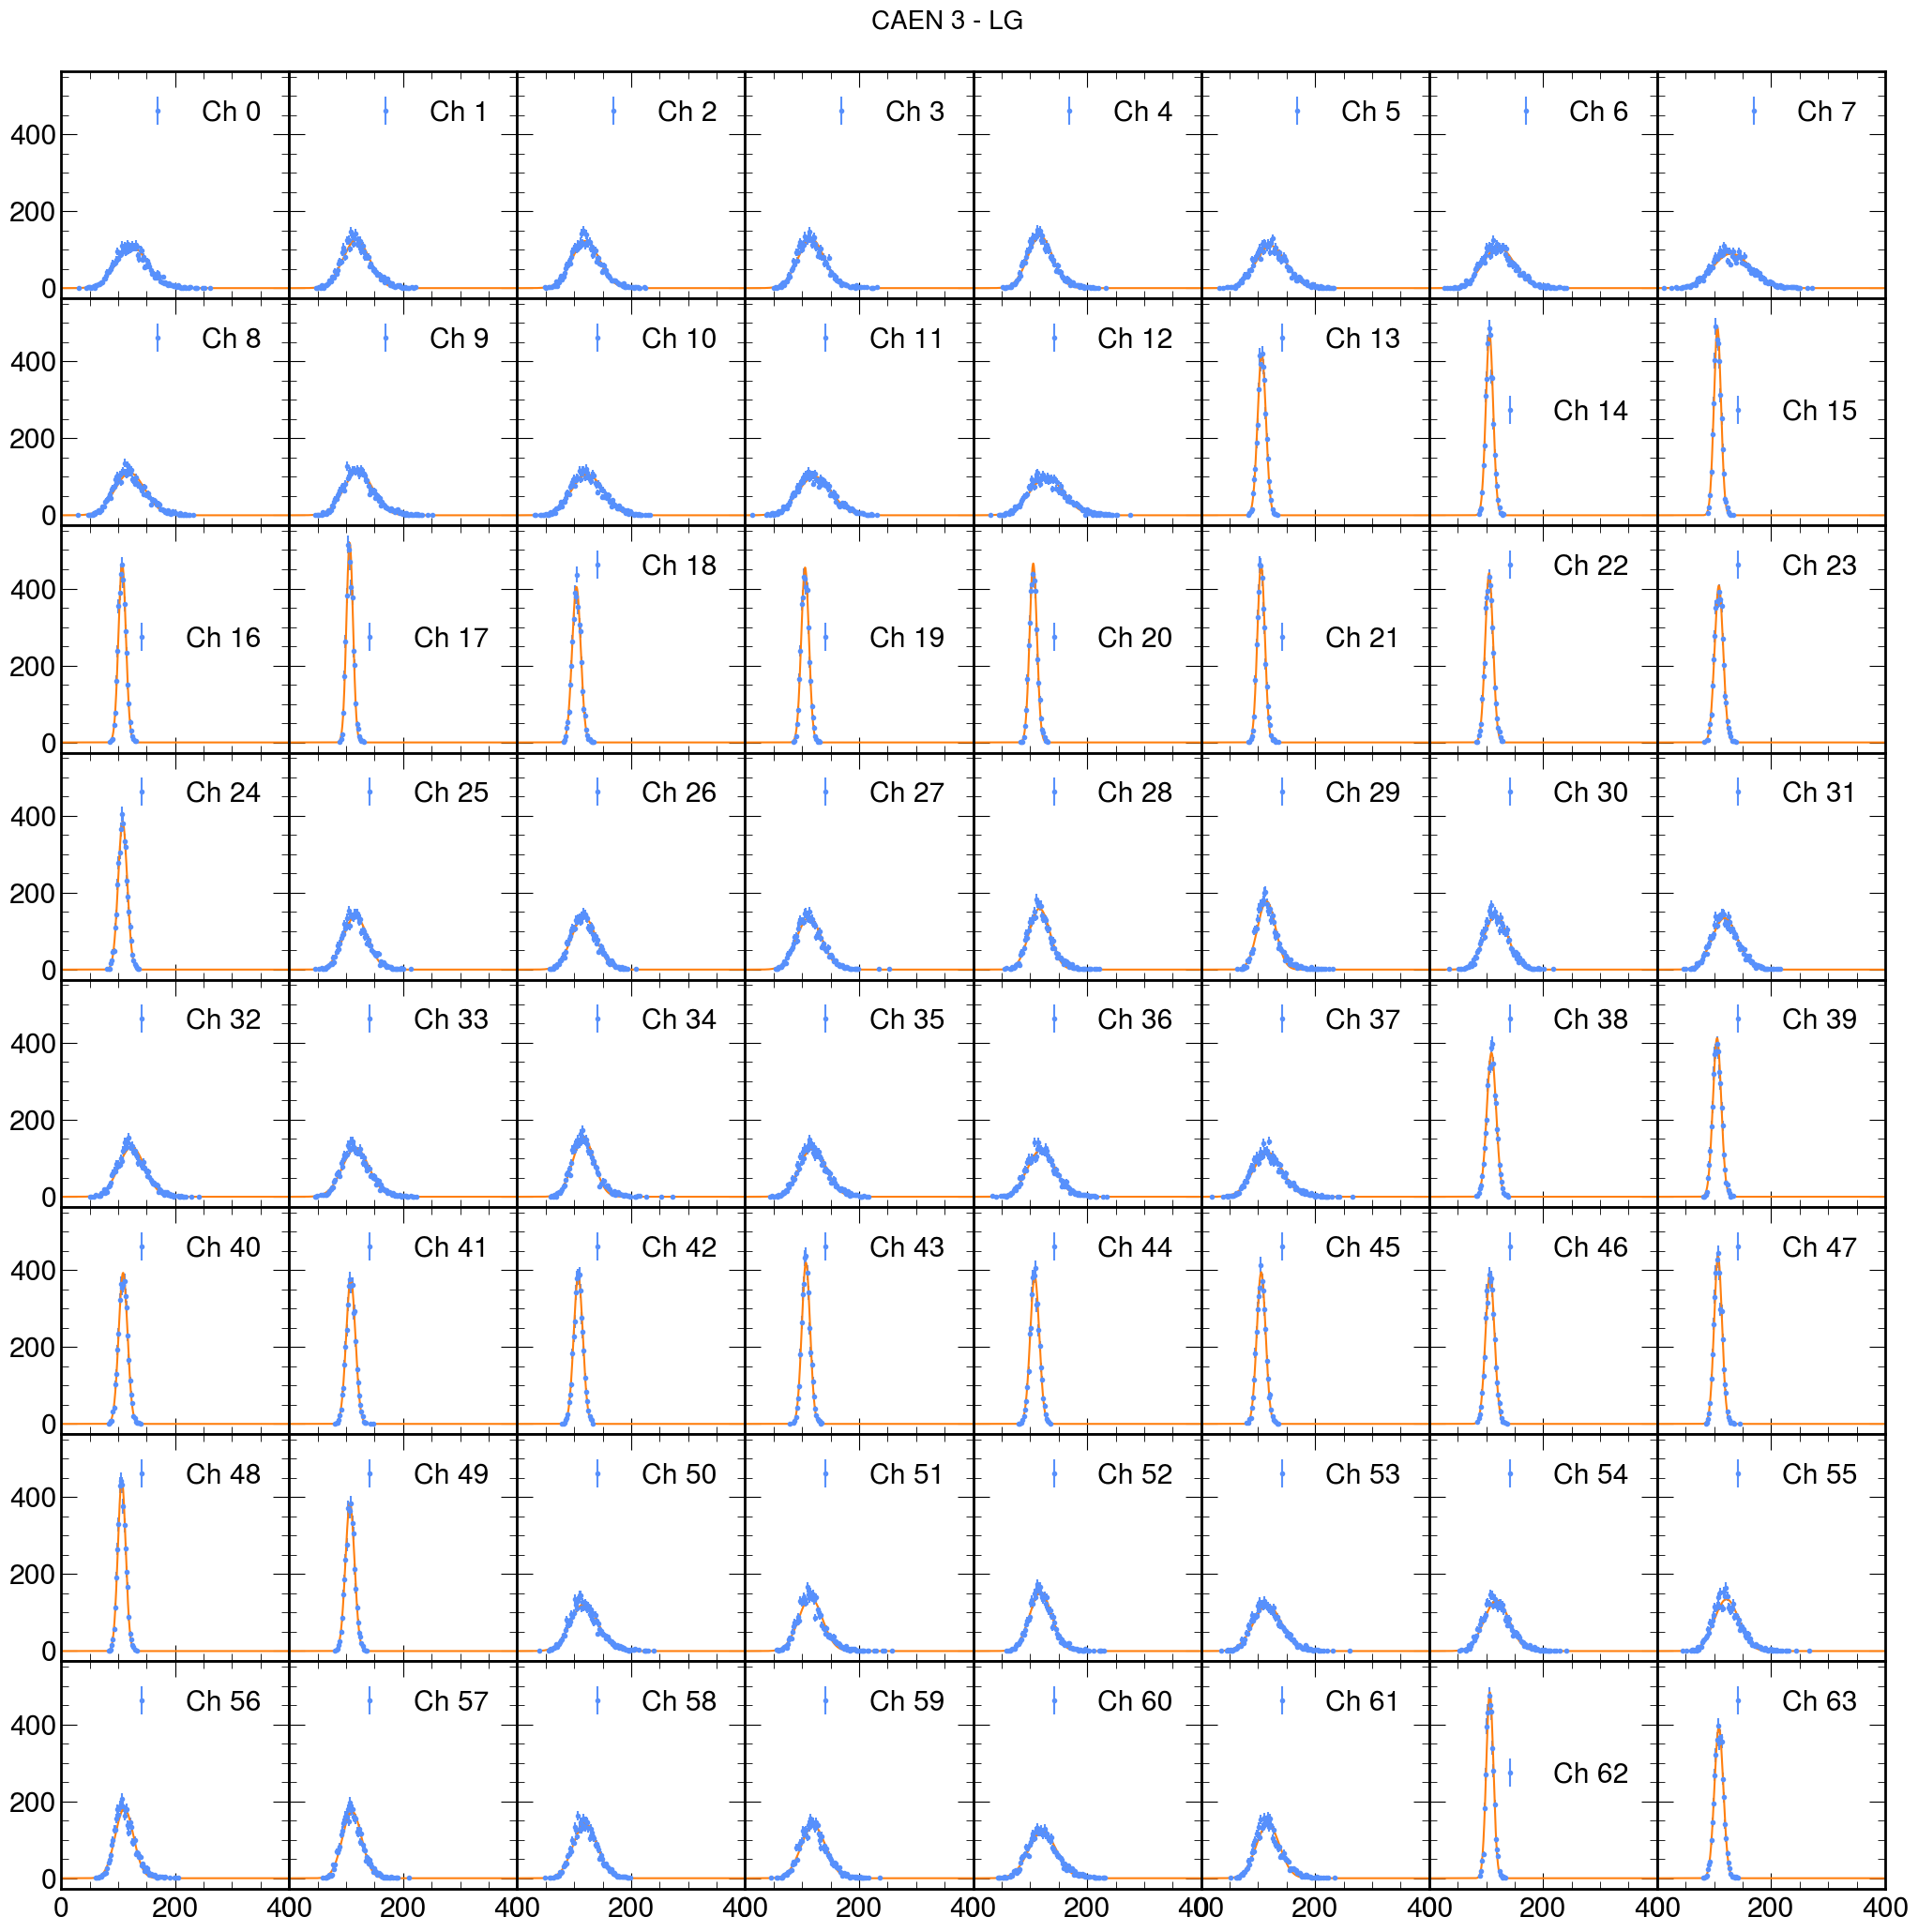

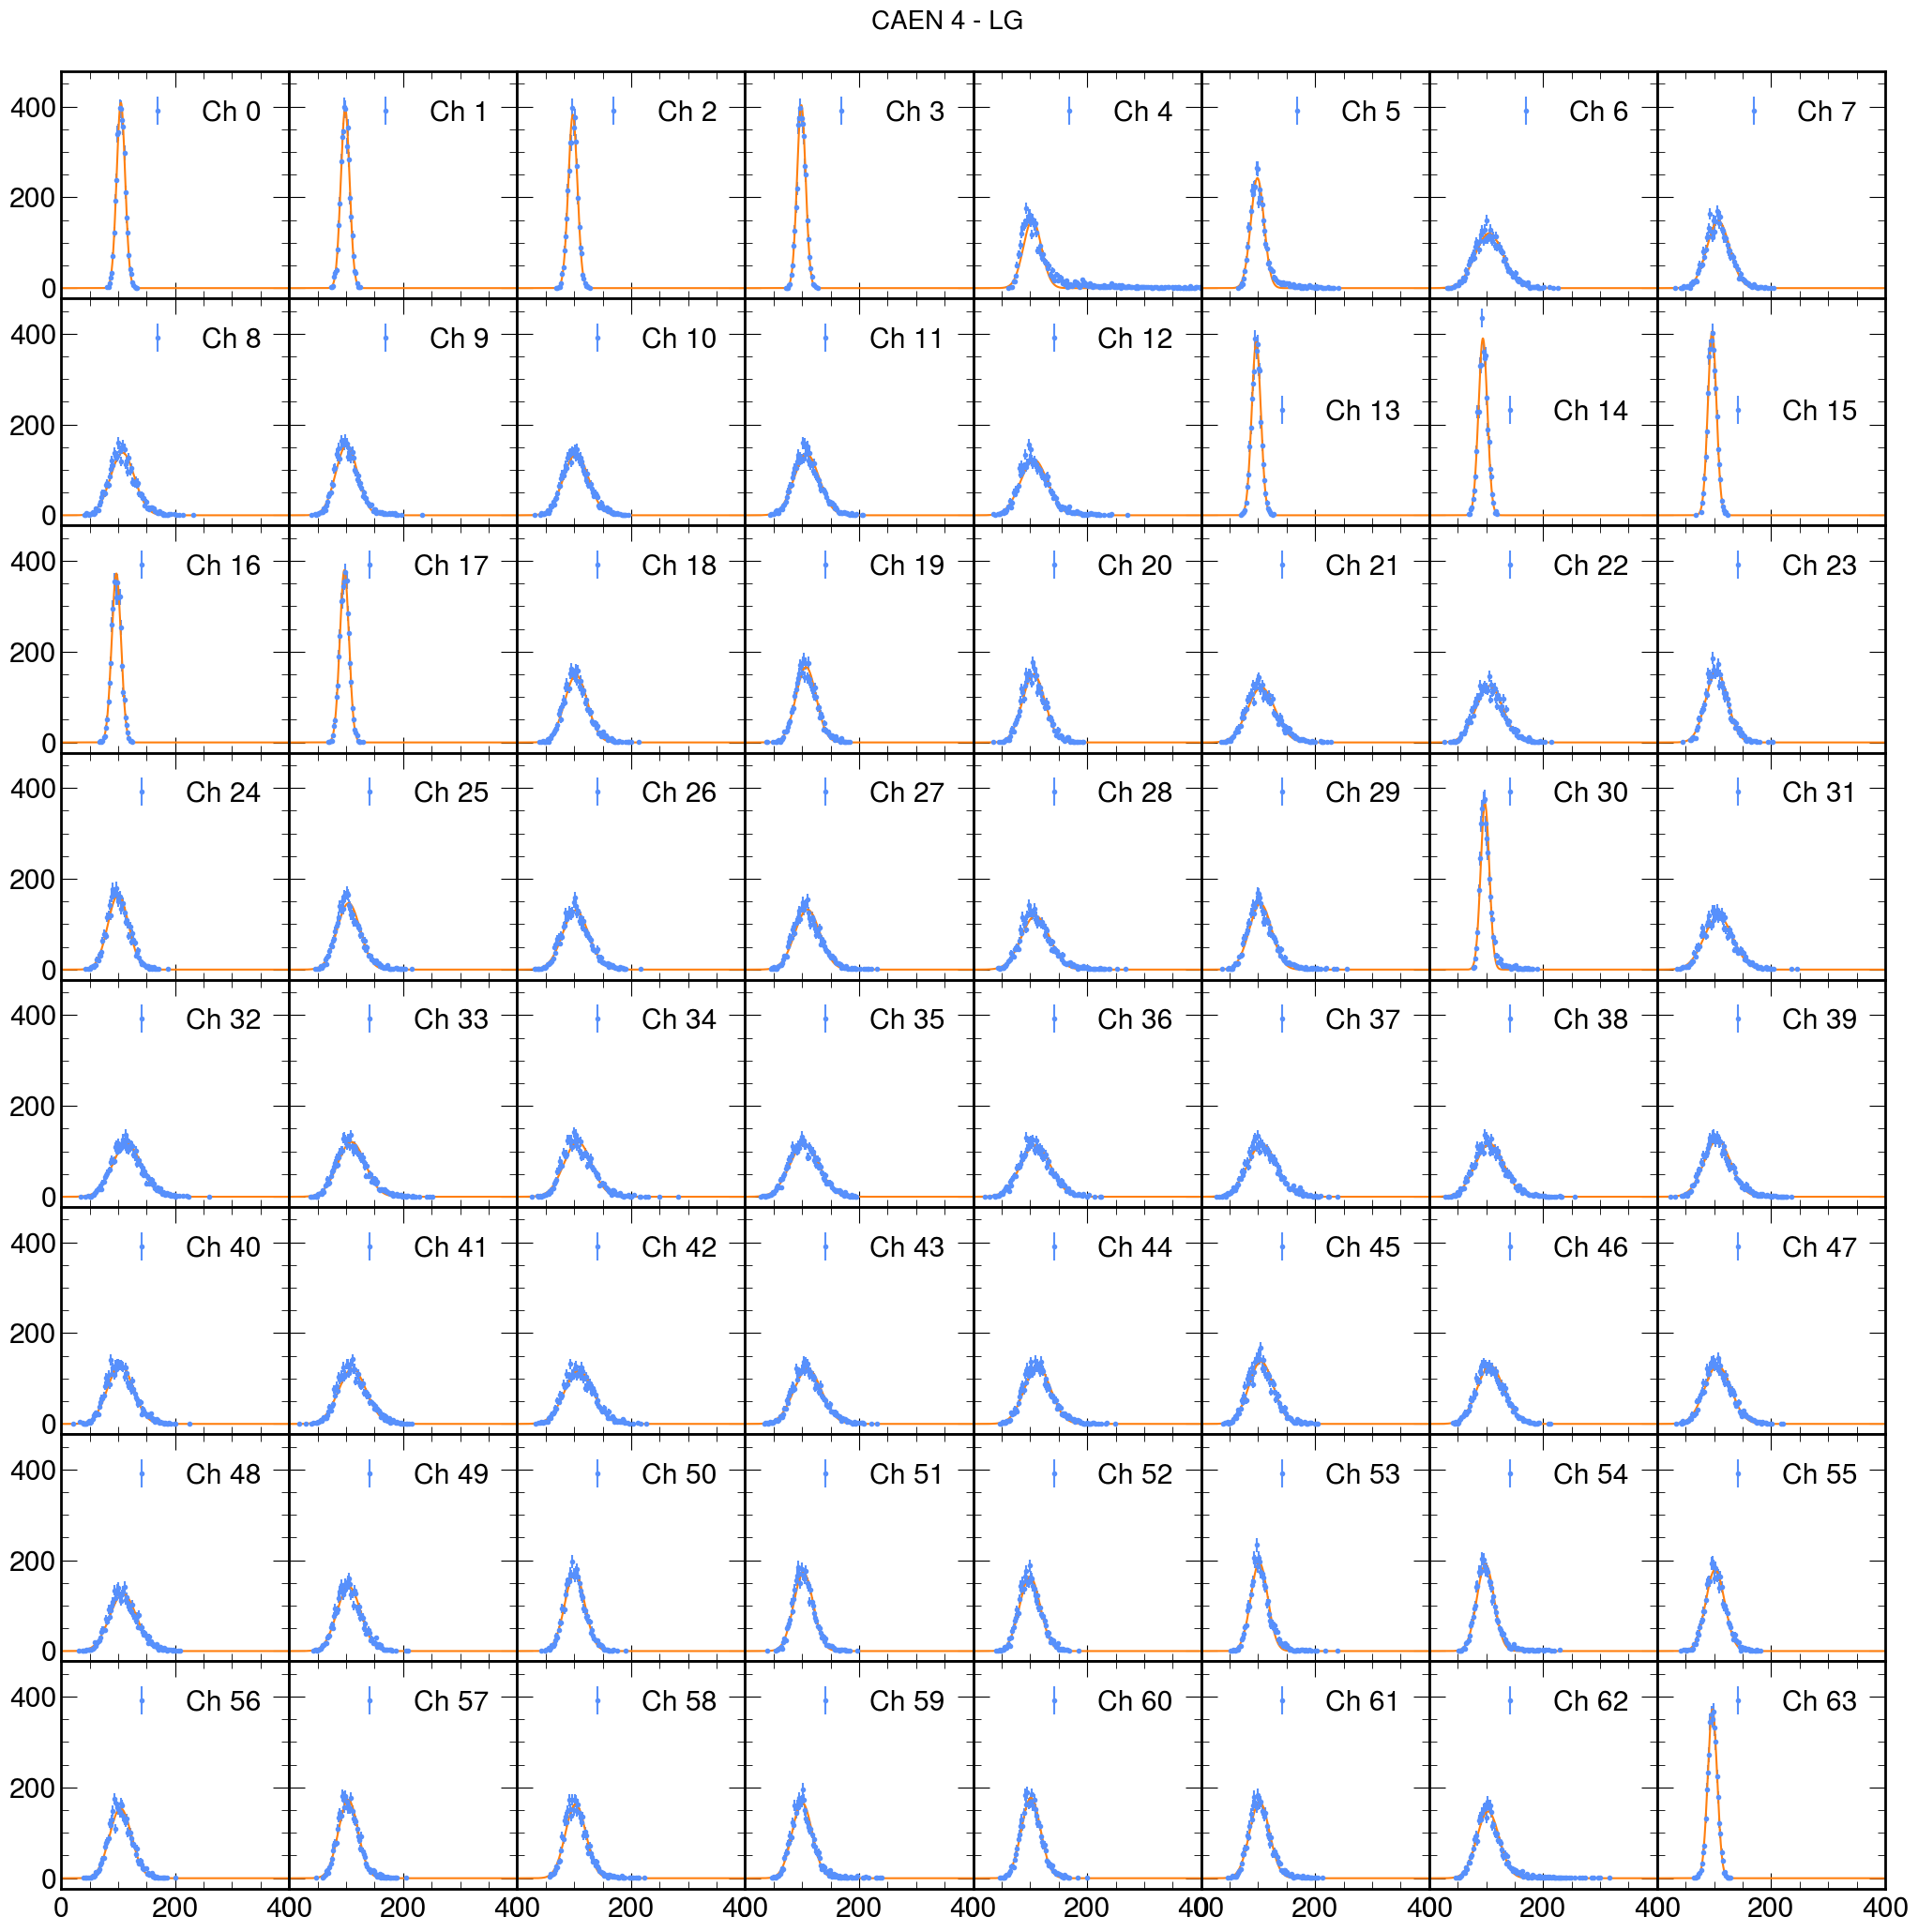

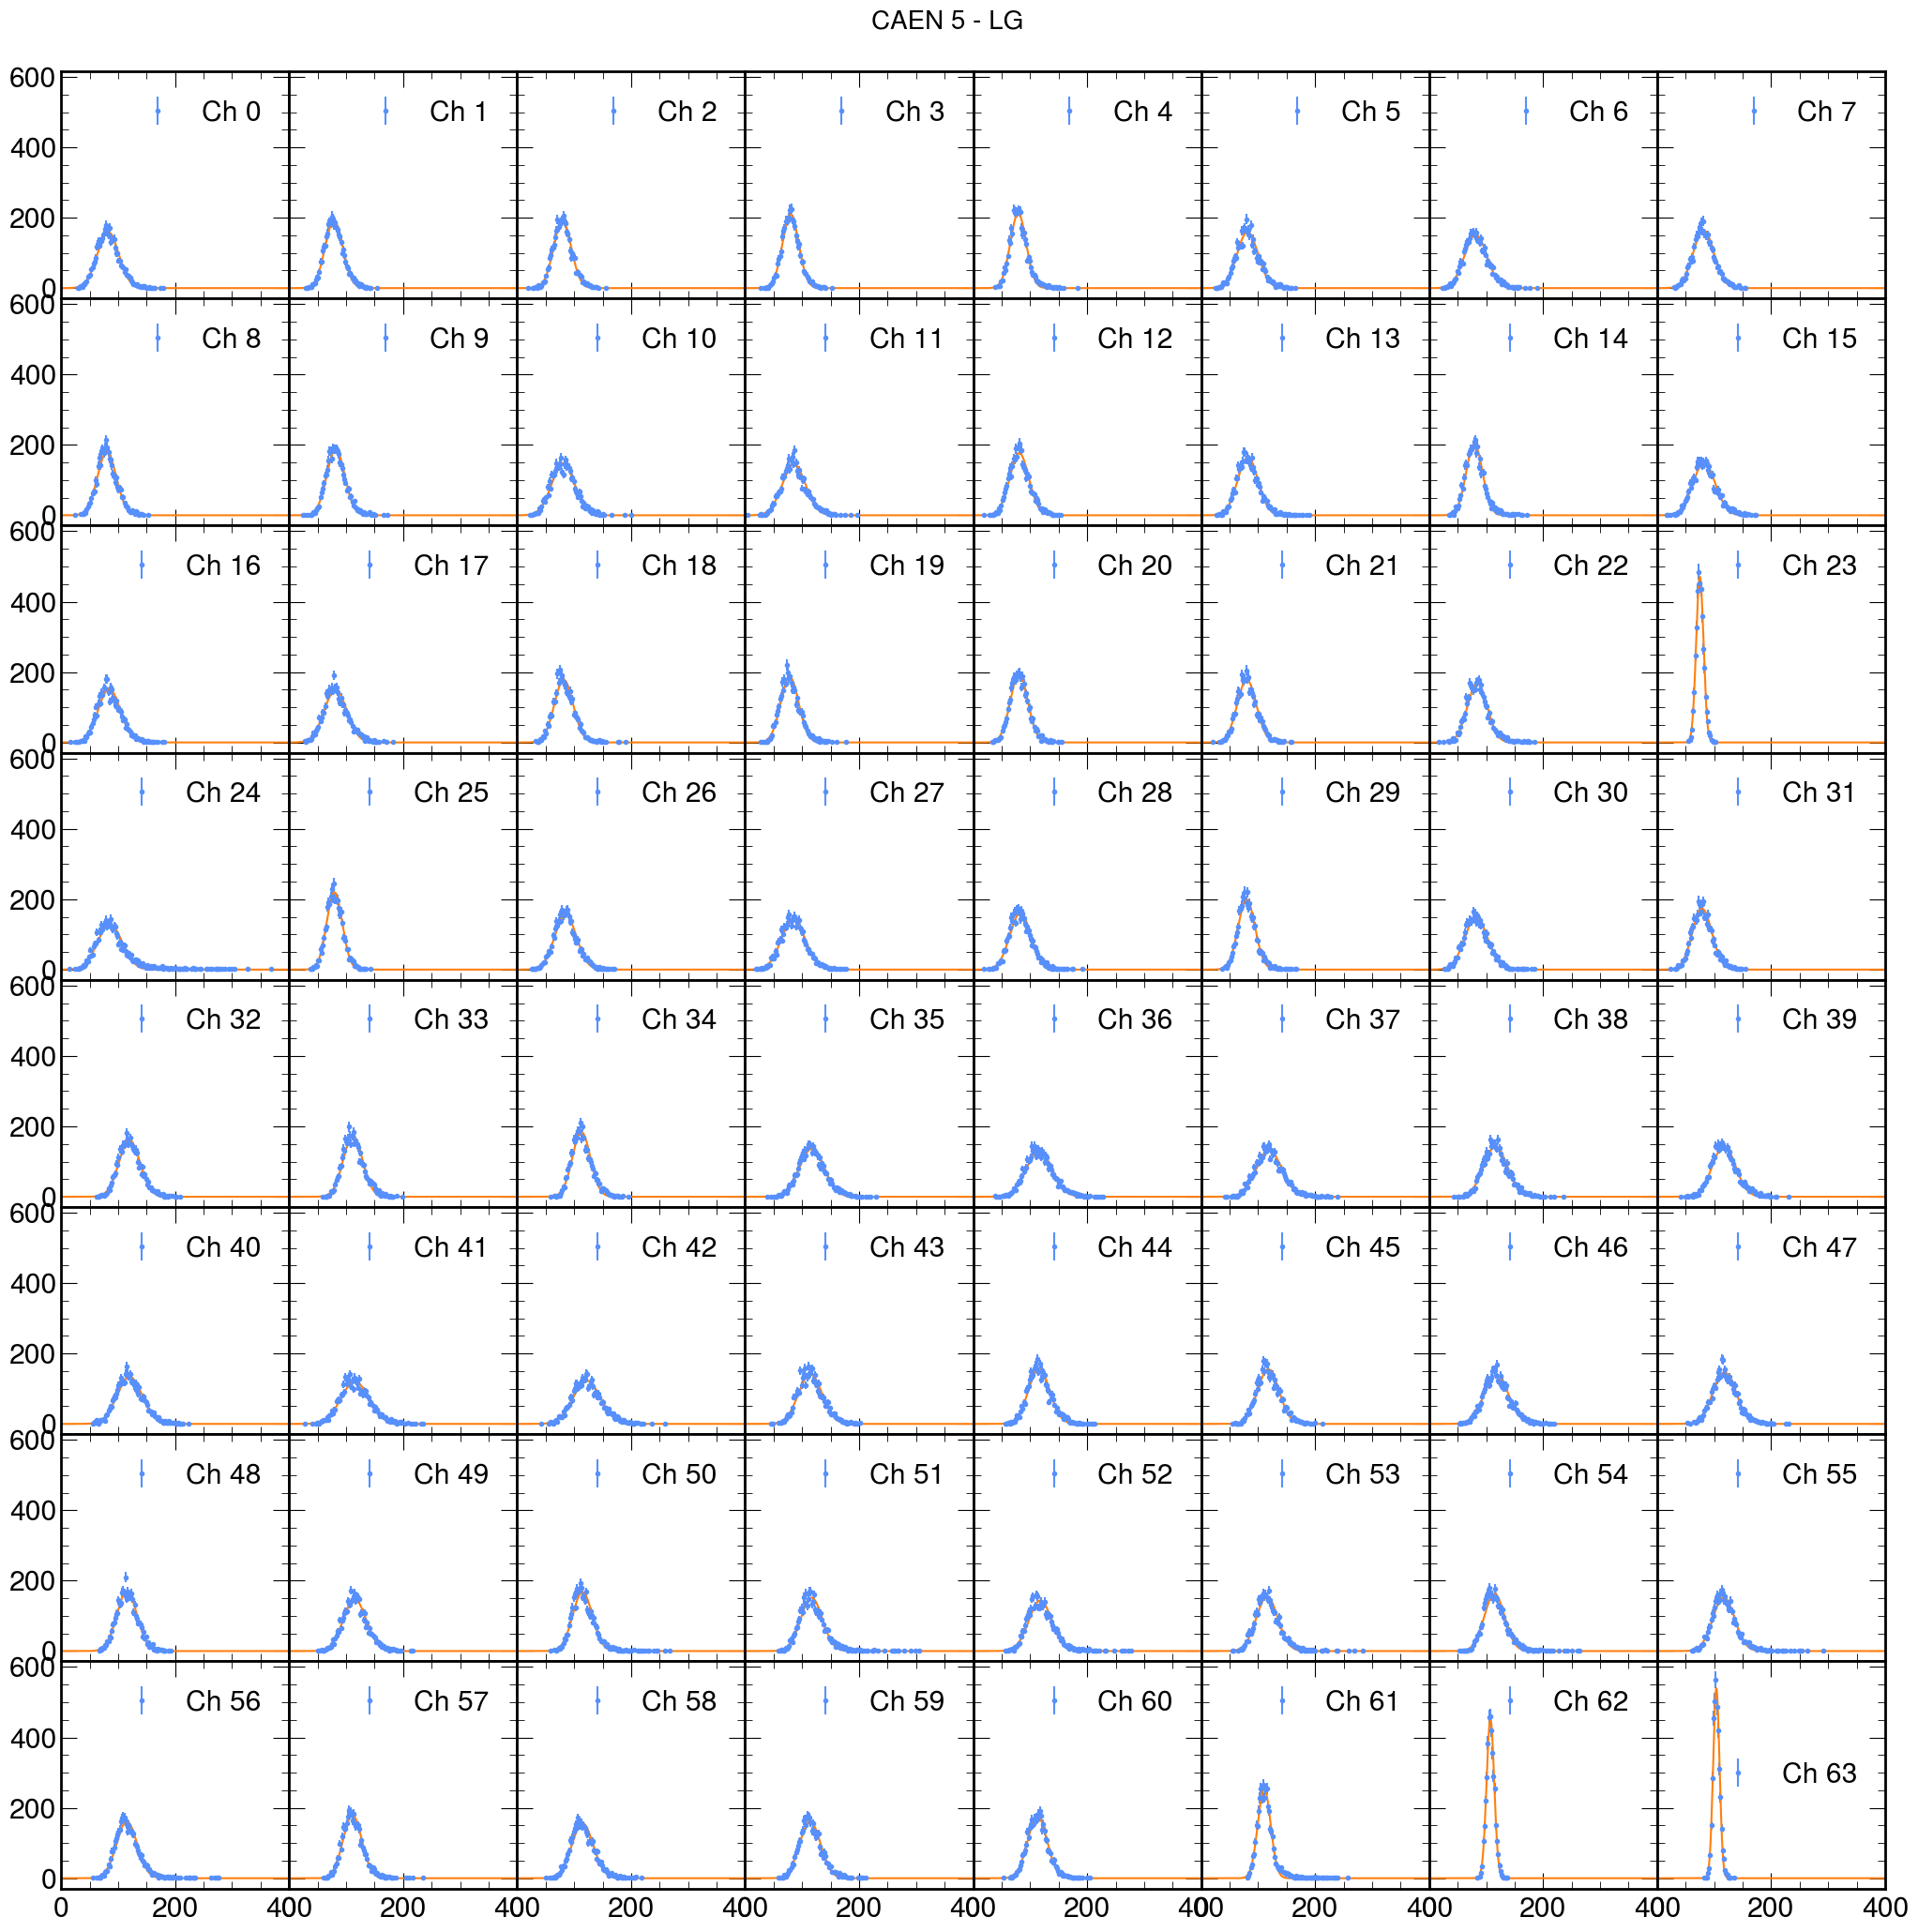

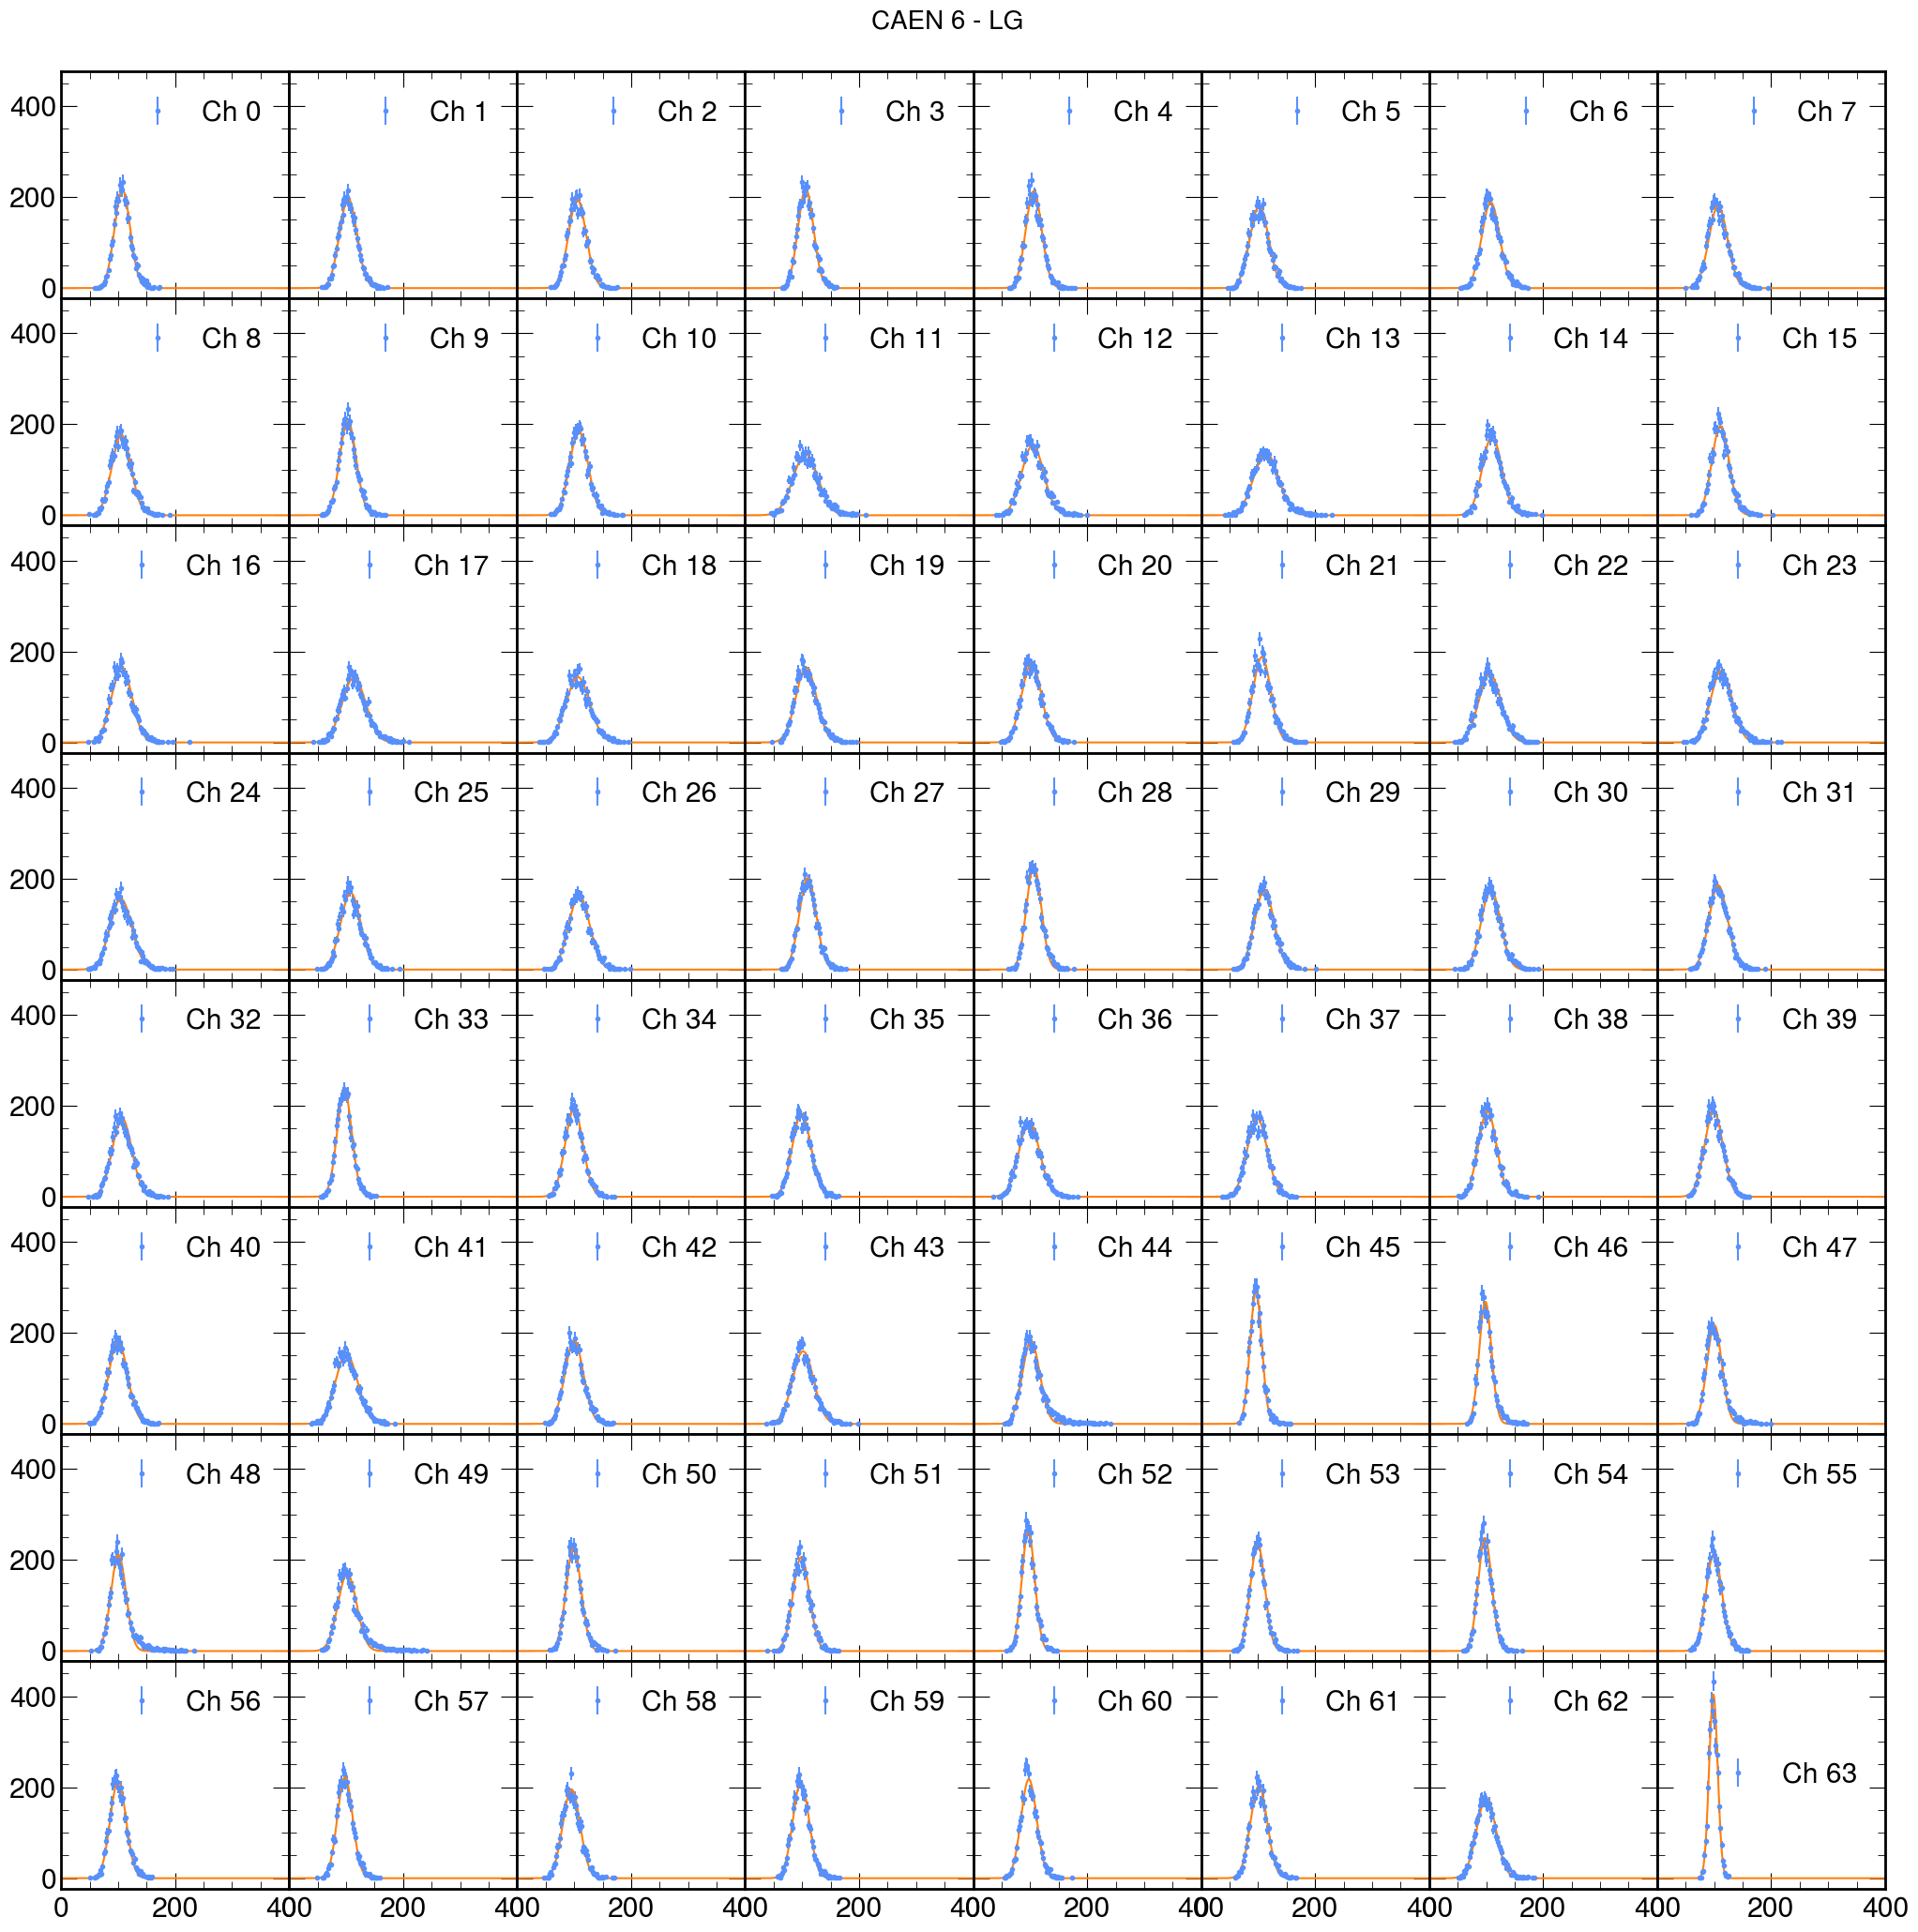

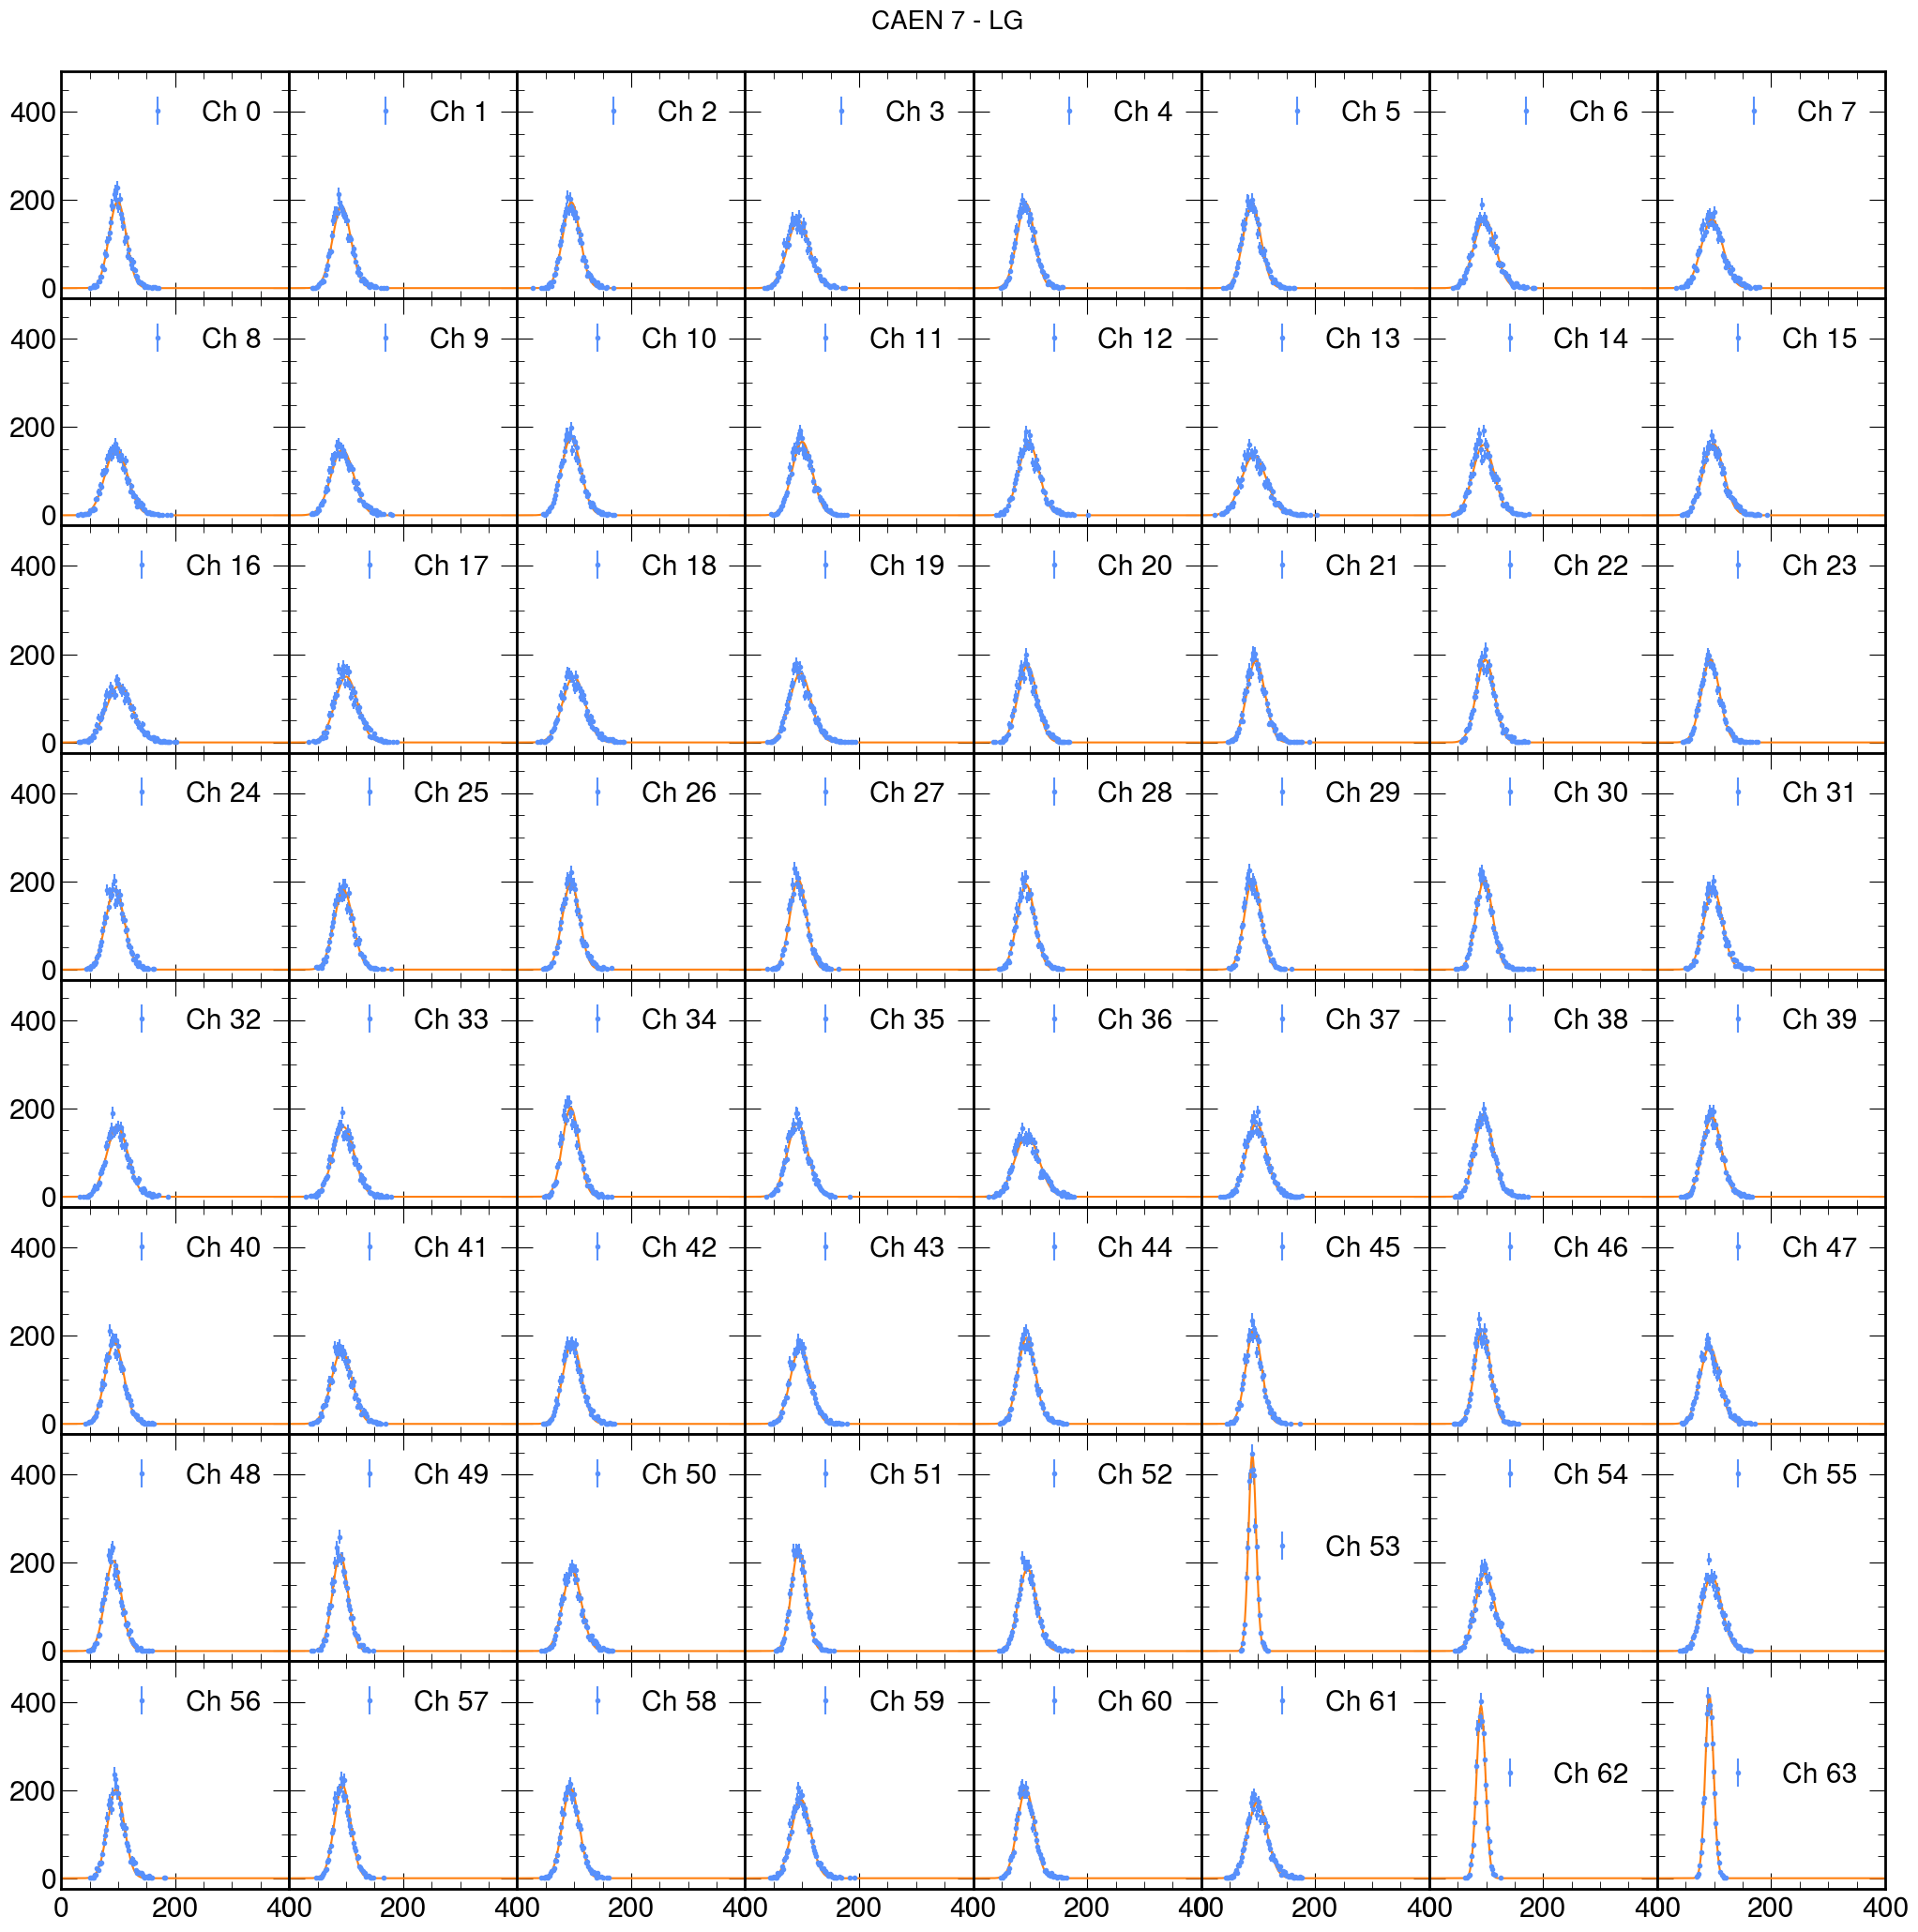

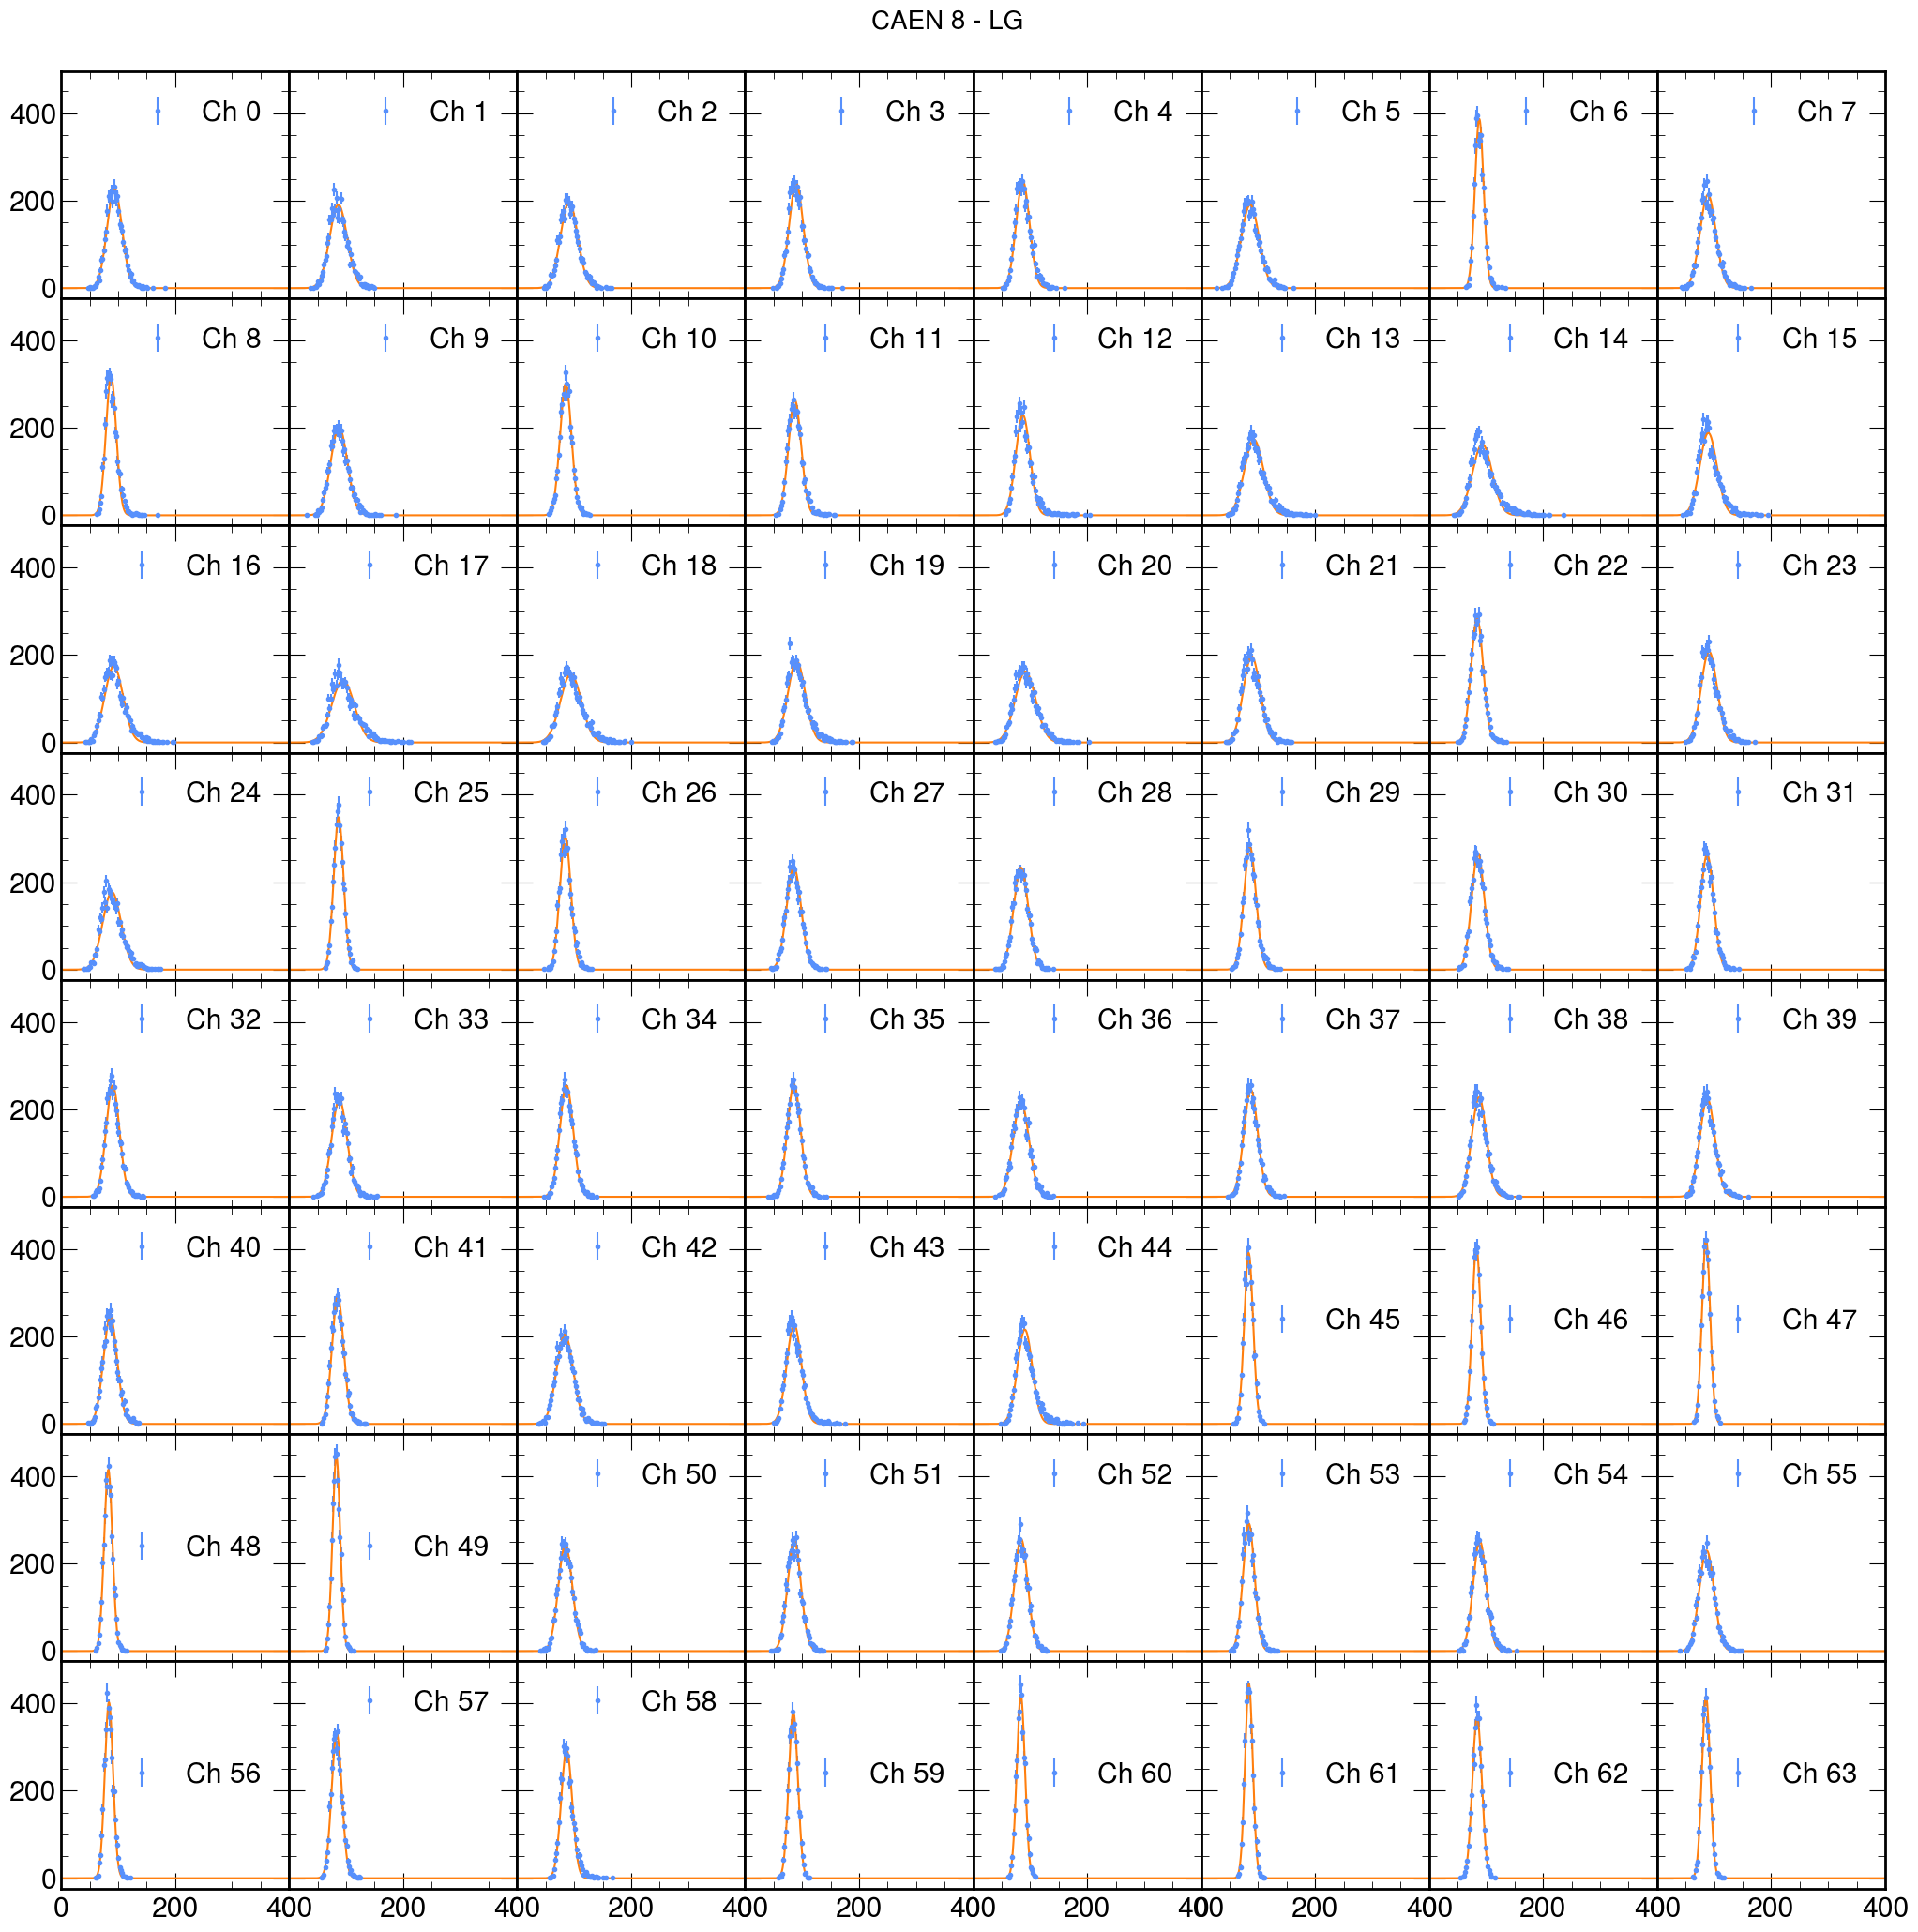

In [4]:
LGPeds, LGPedStd, LGPedsErr, LGPedStdErr = [], [], [], []
configure_plotting()
for i in range(9):
    plot_caen_histograms(data_DF, caen_unit=i, gain_type="LG", Peds=LGPeds, PedStds=LGPedStd, PedErrs=LGPedsErr, PedStdErrs=LGPedStdErr)

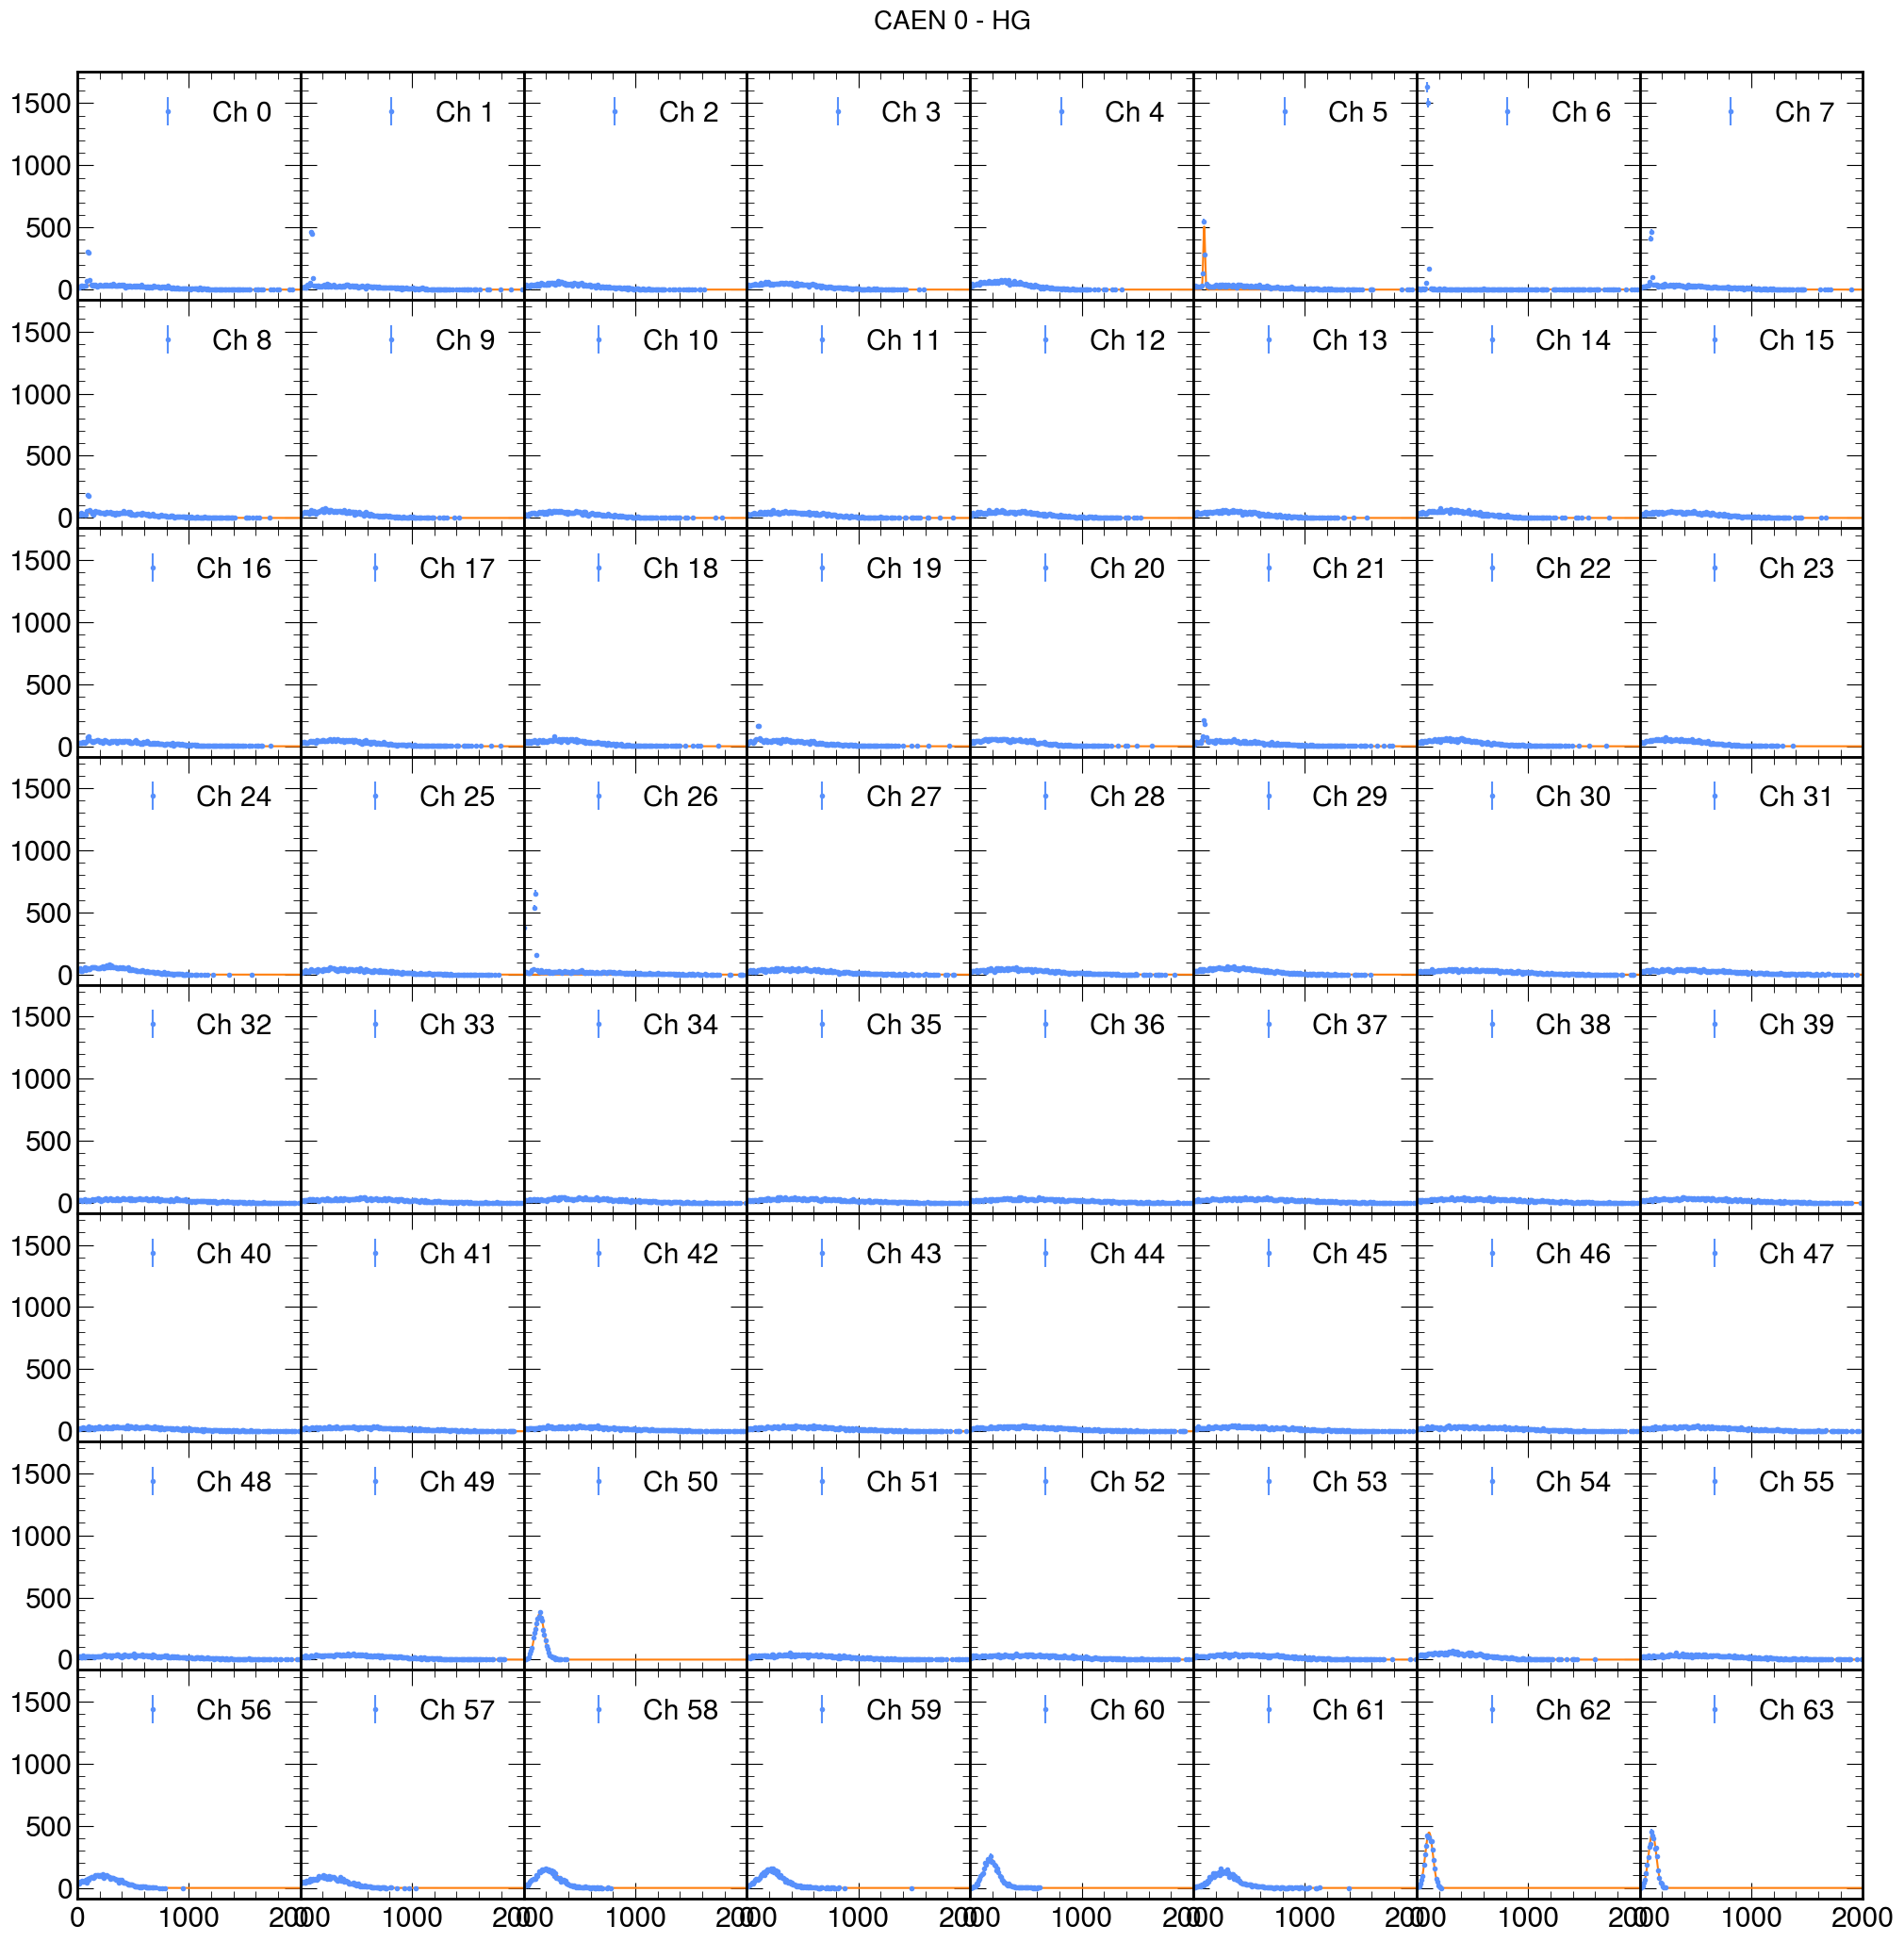

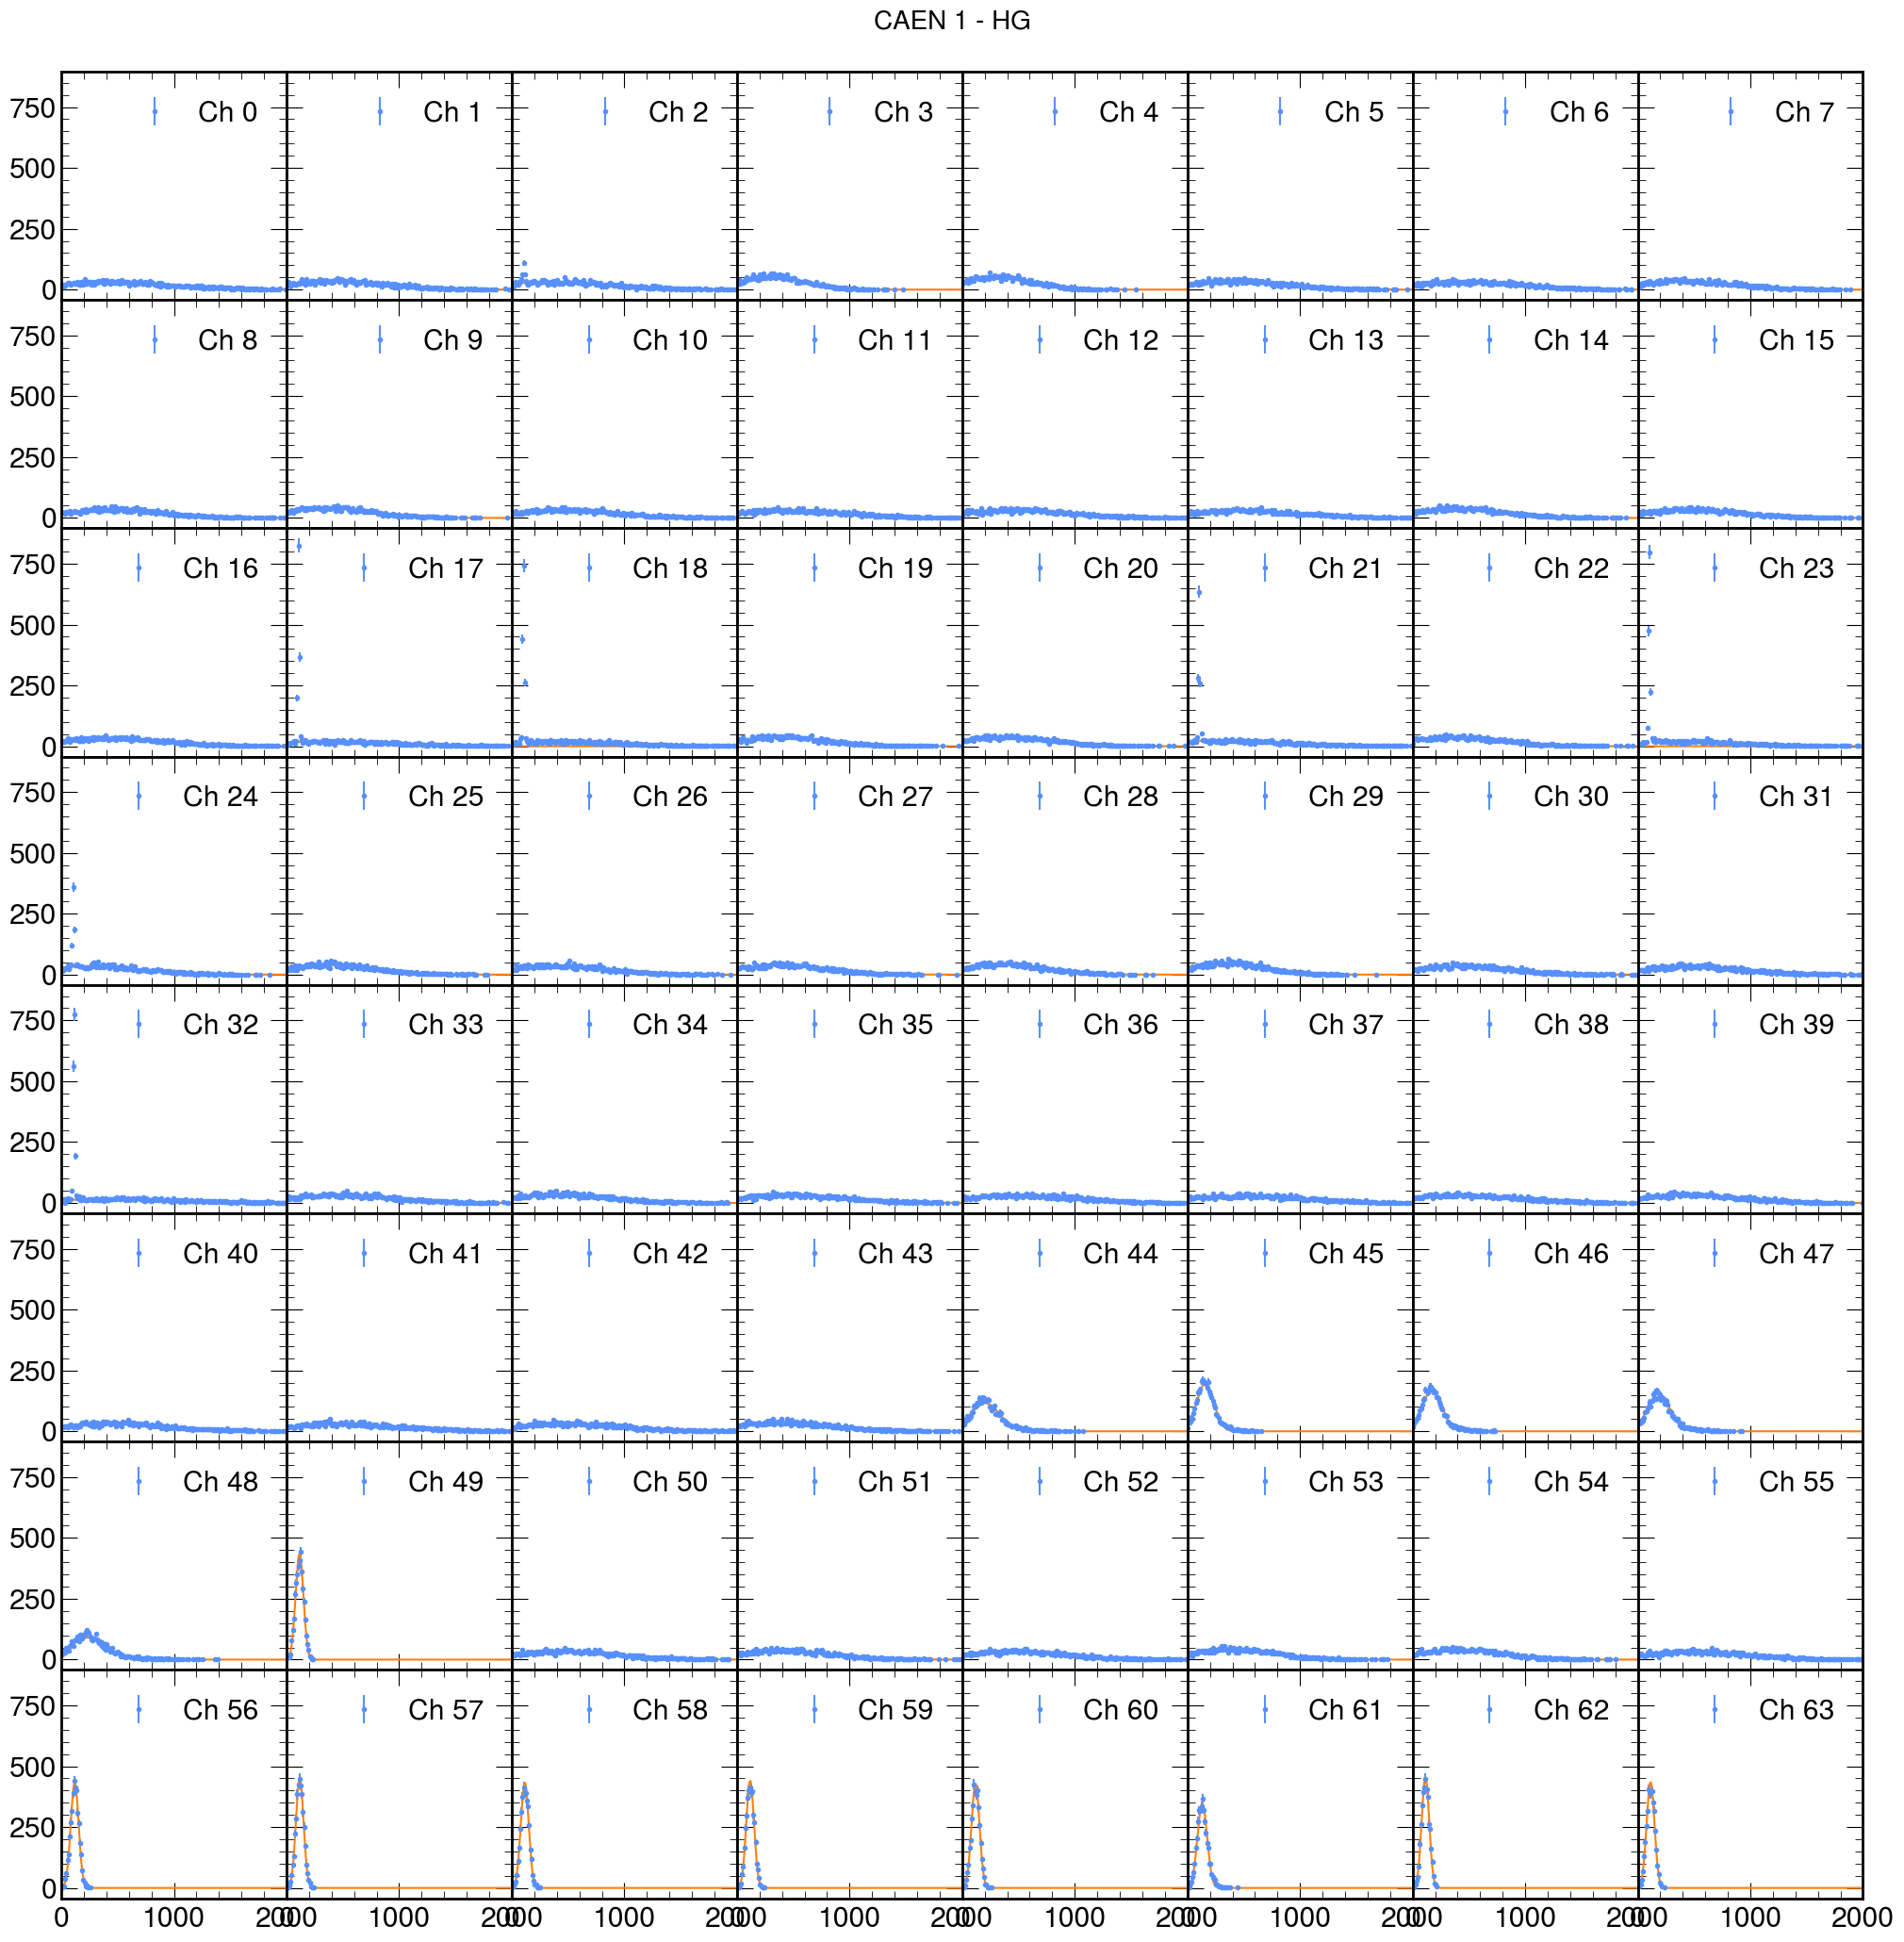

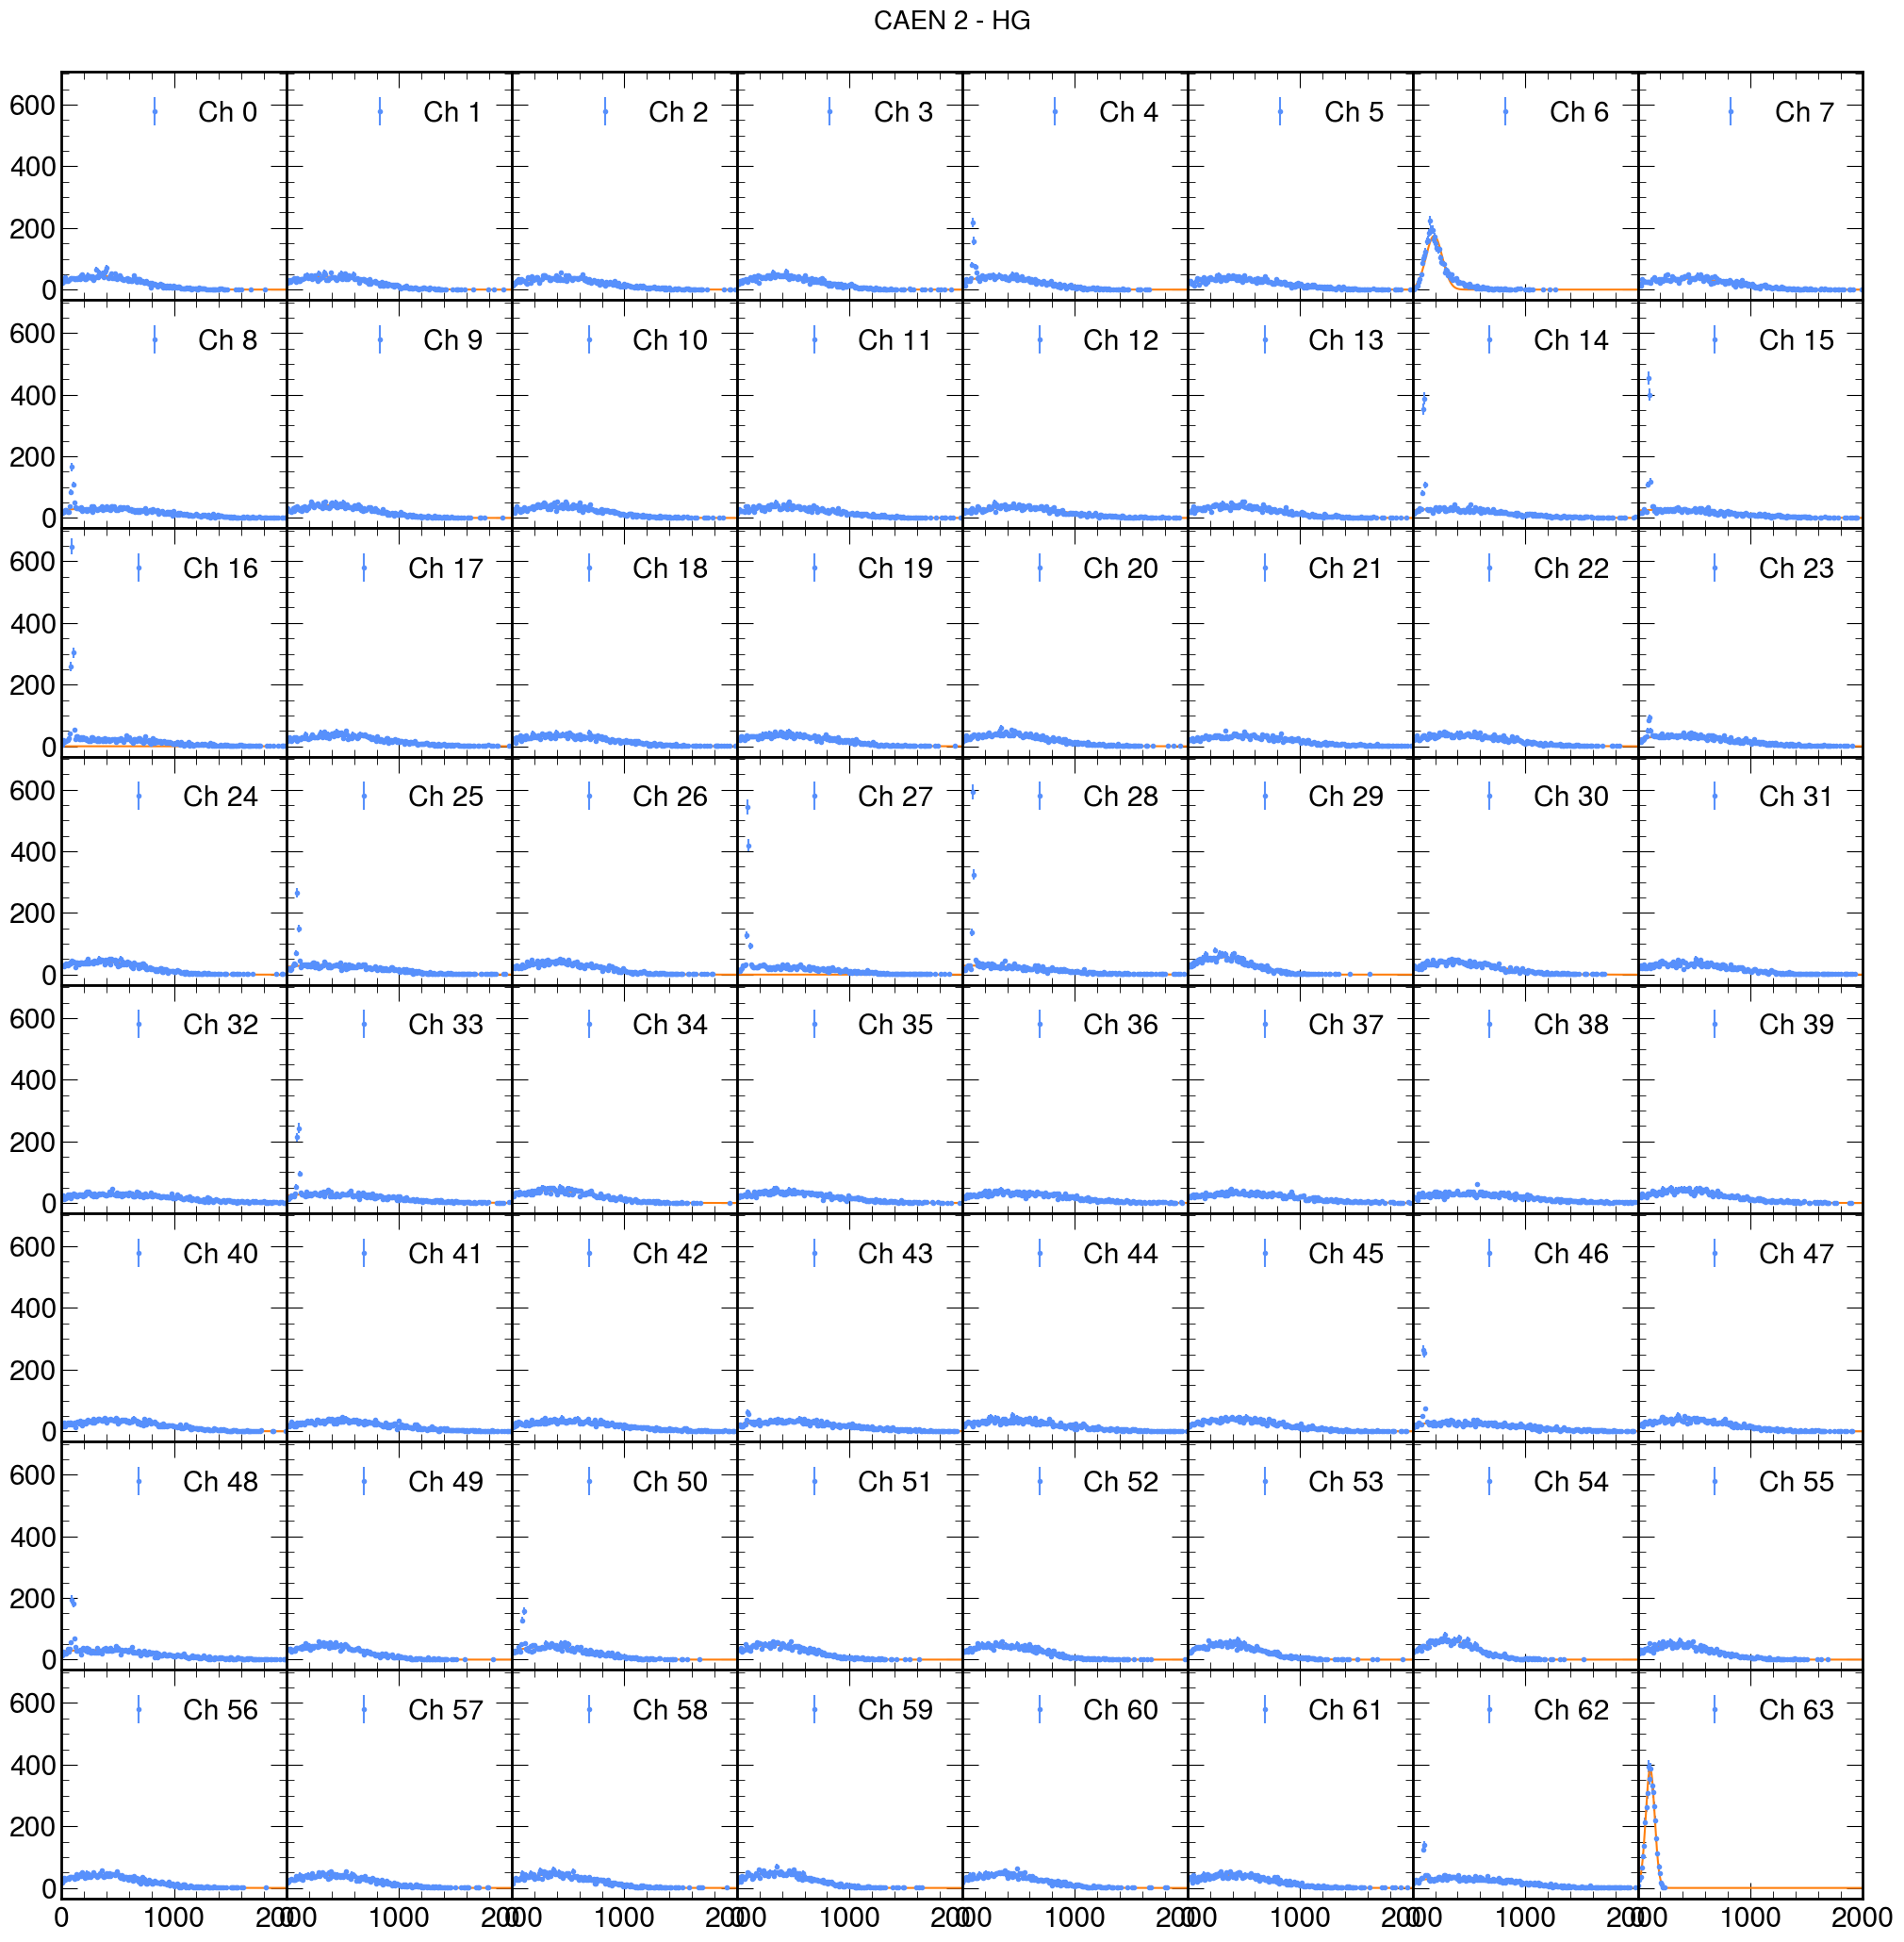

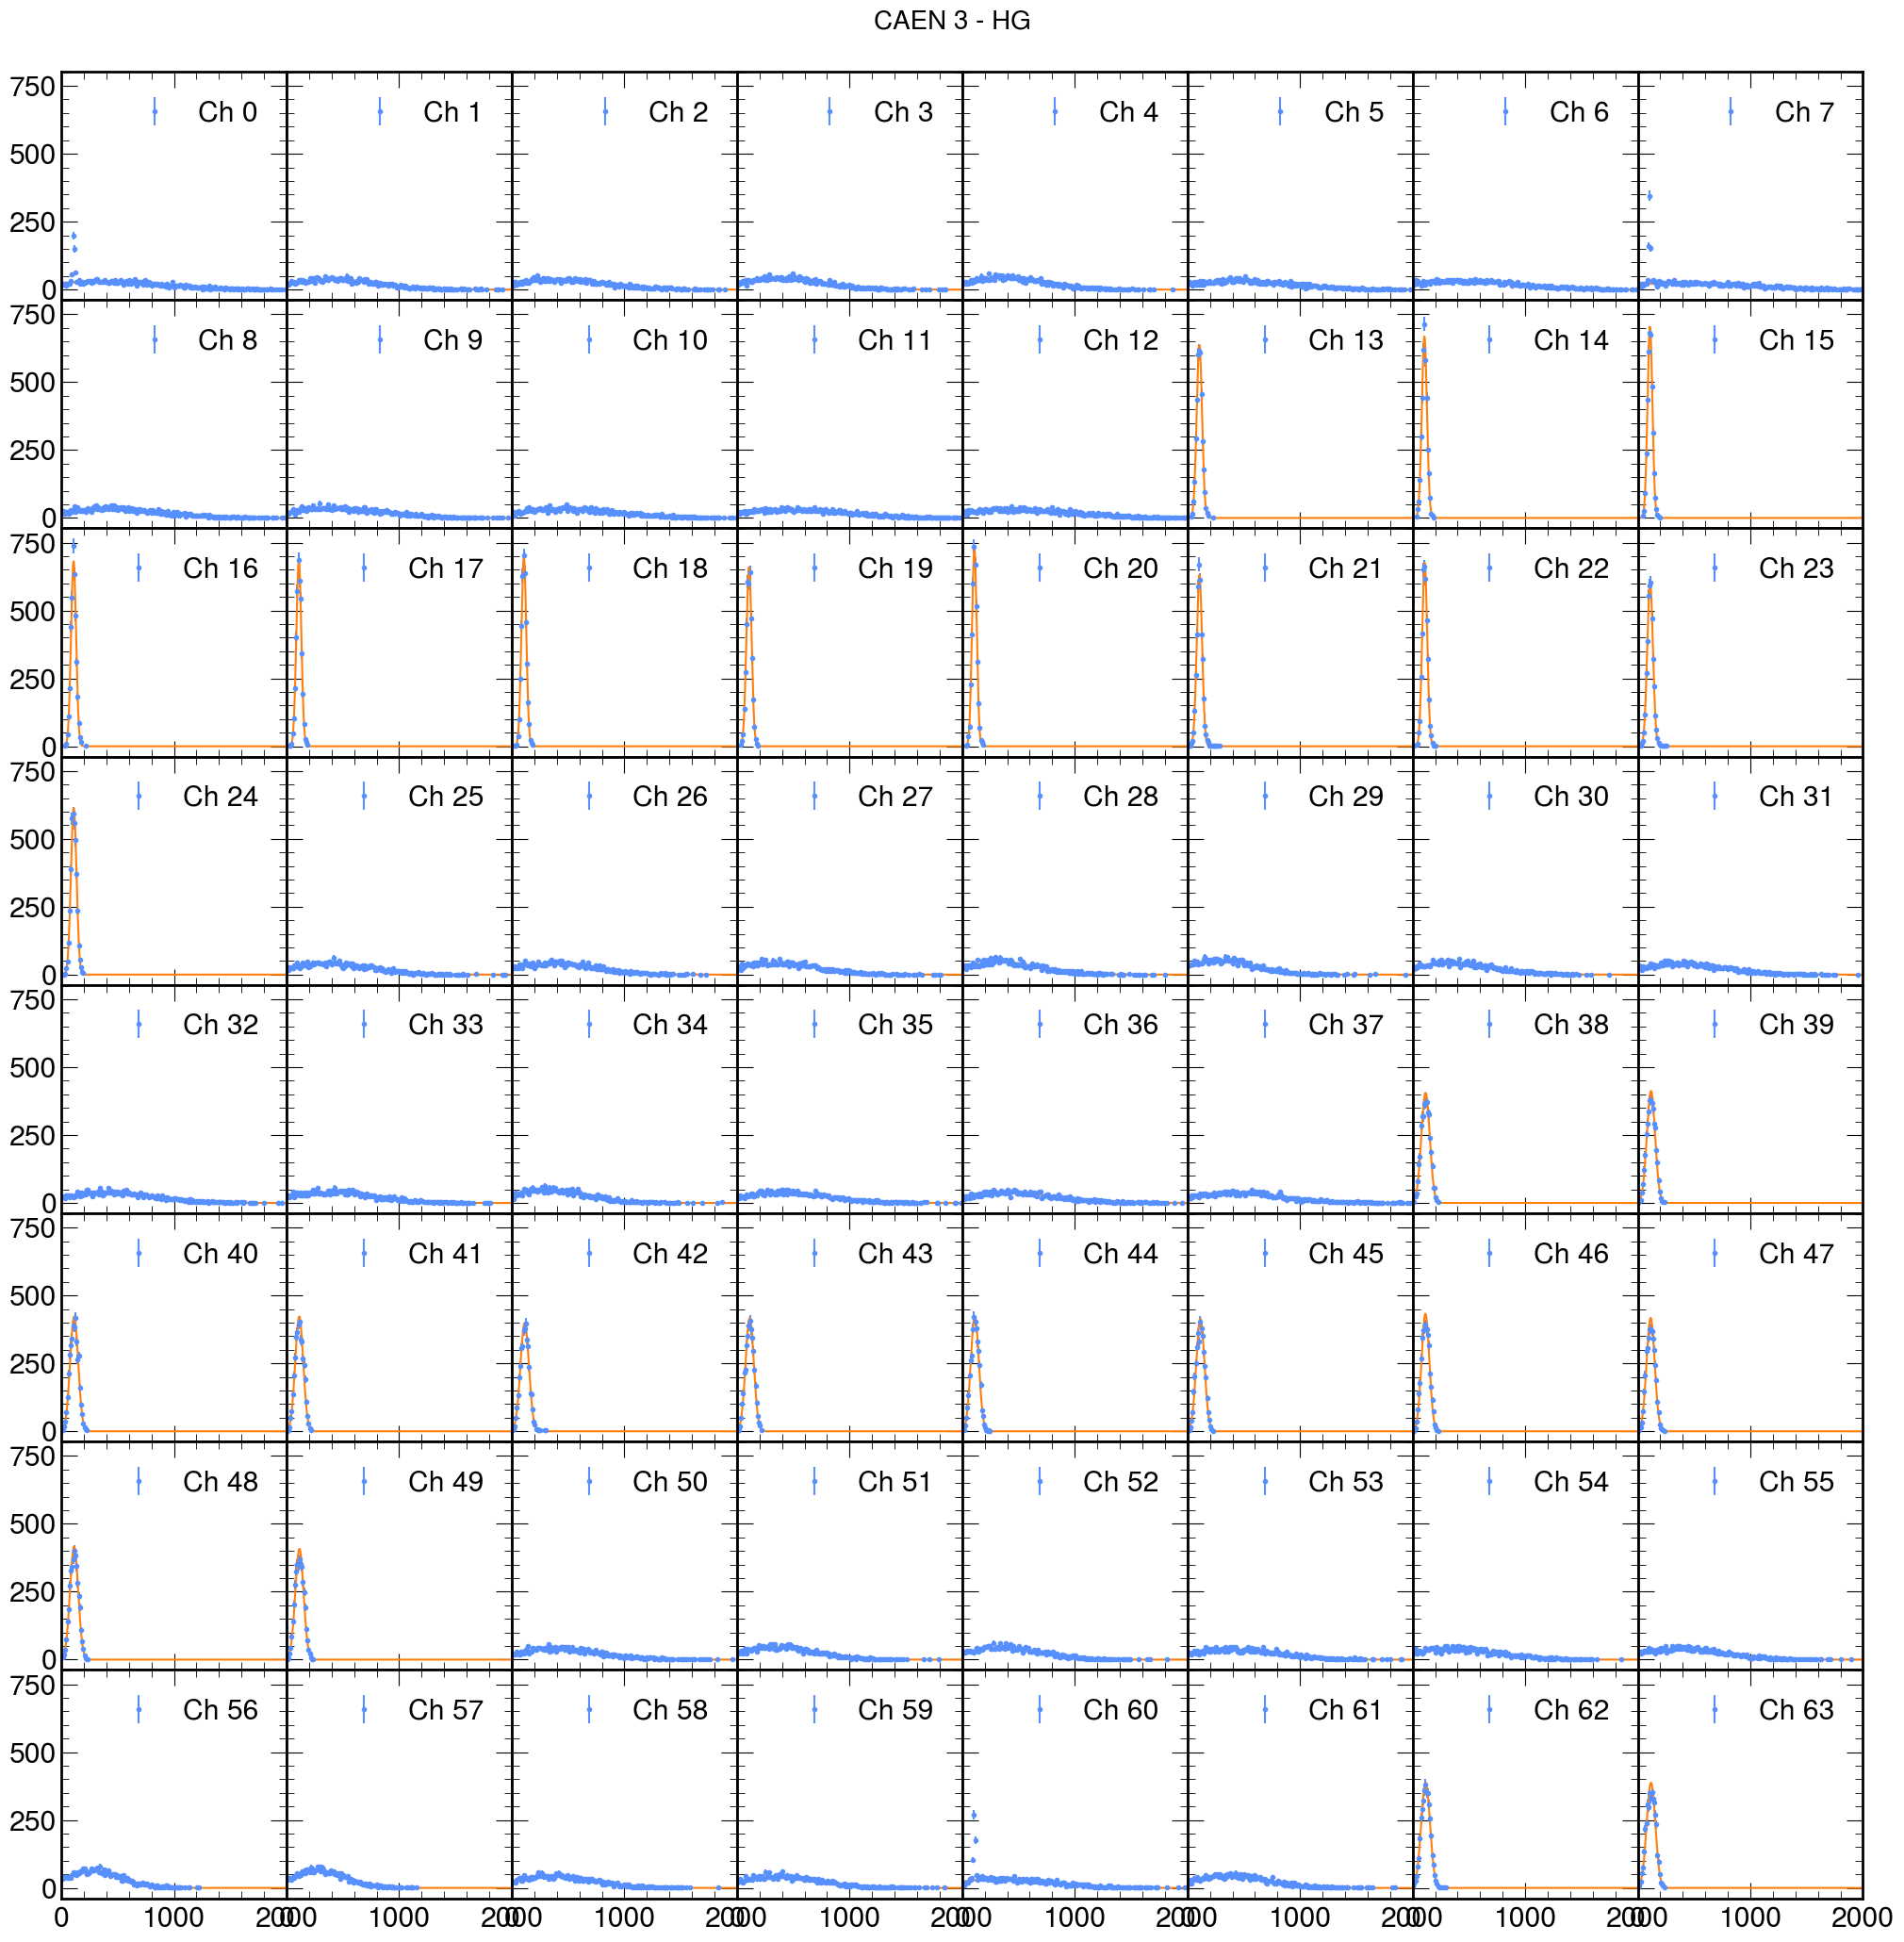

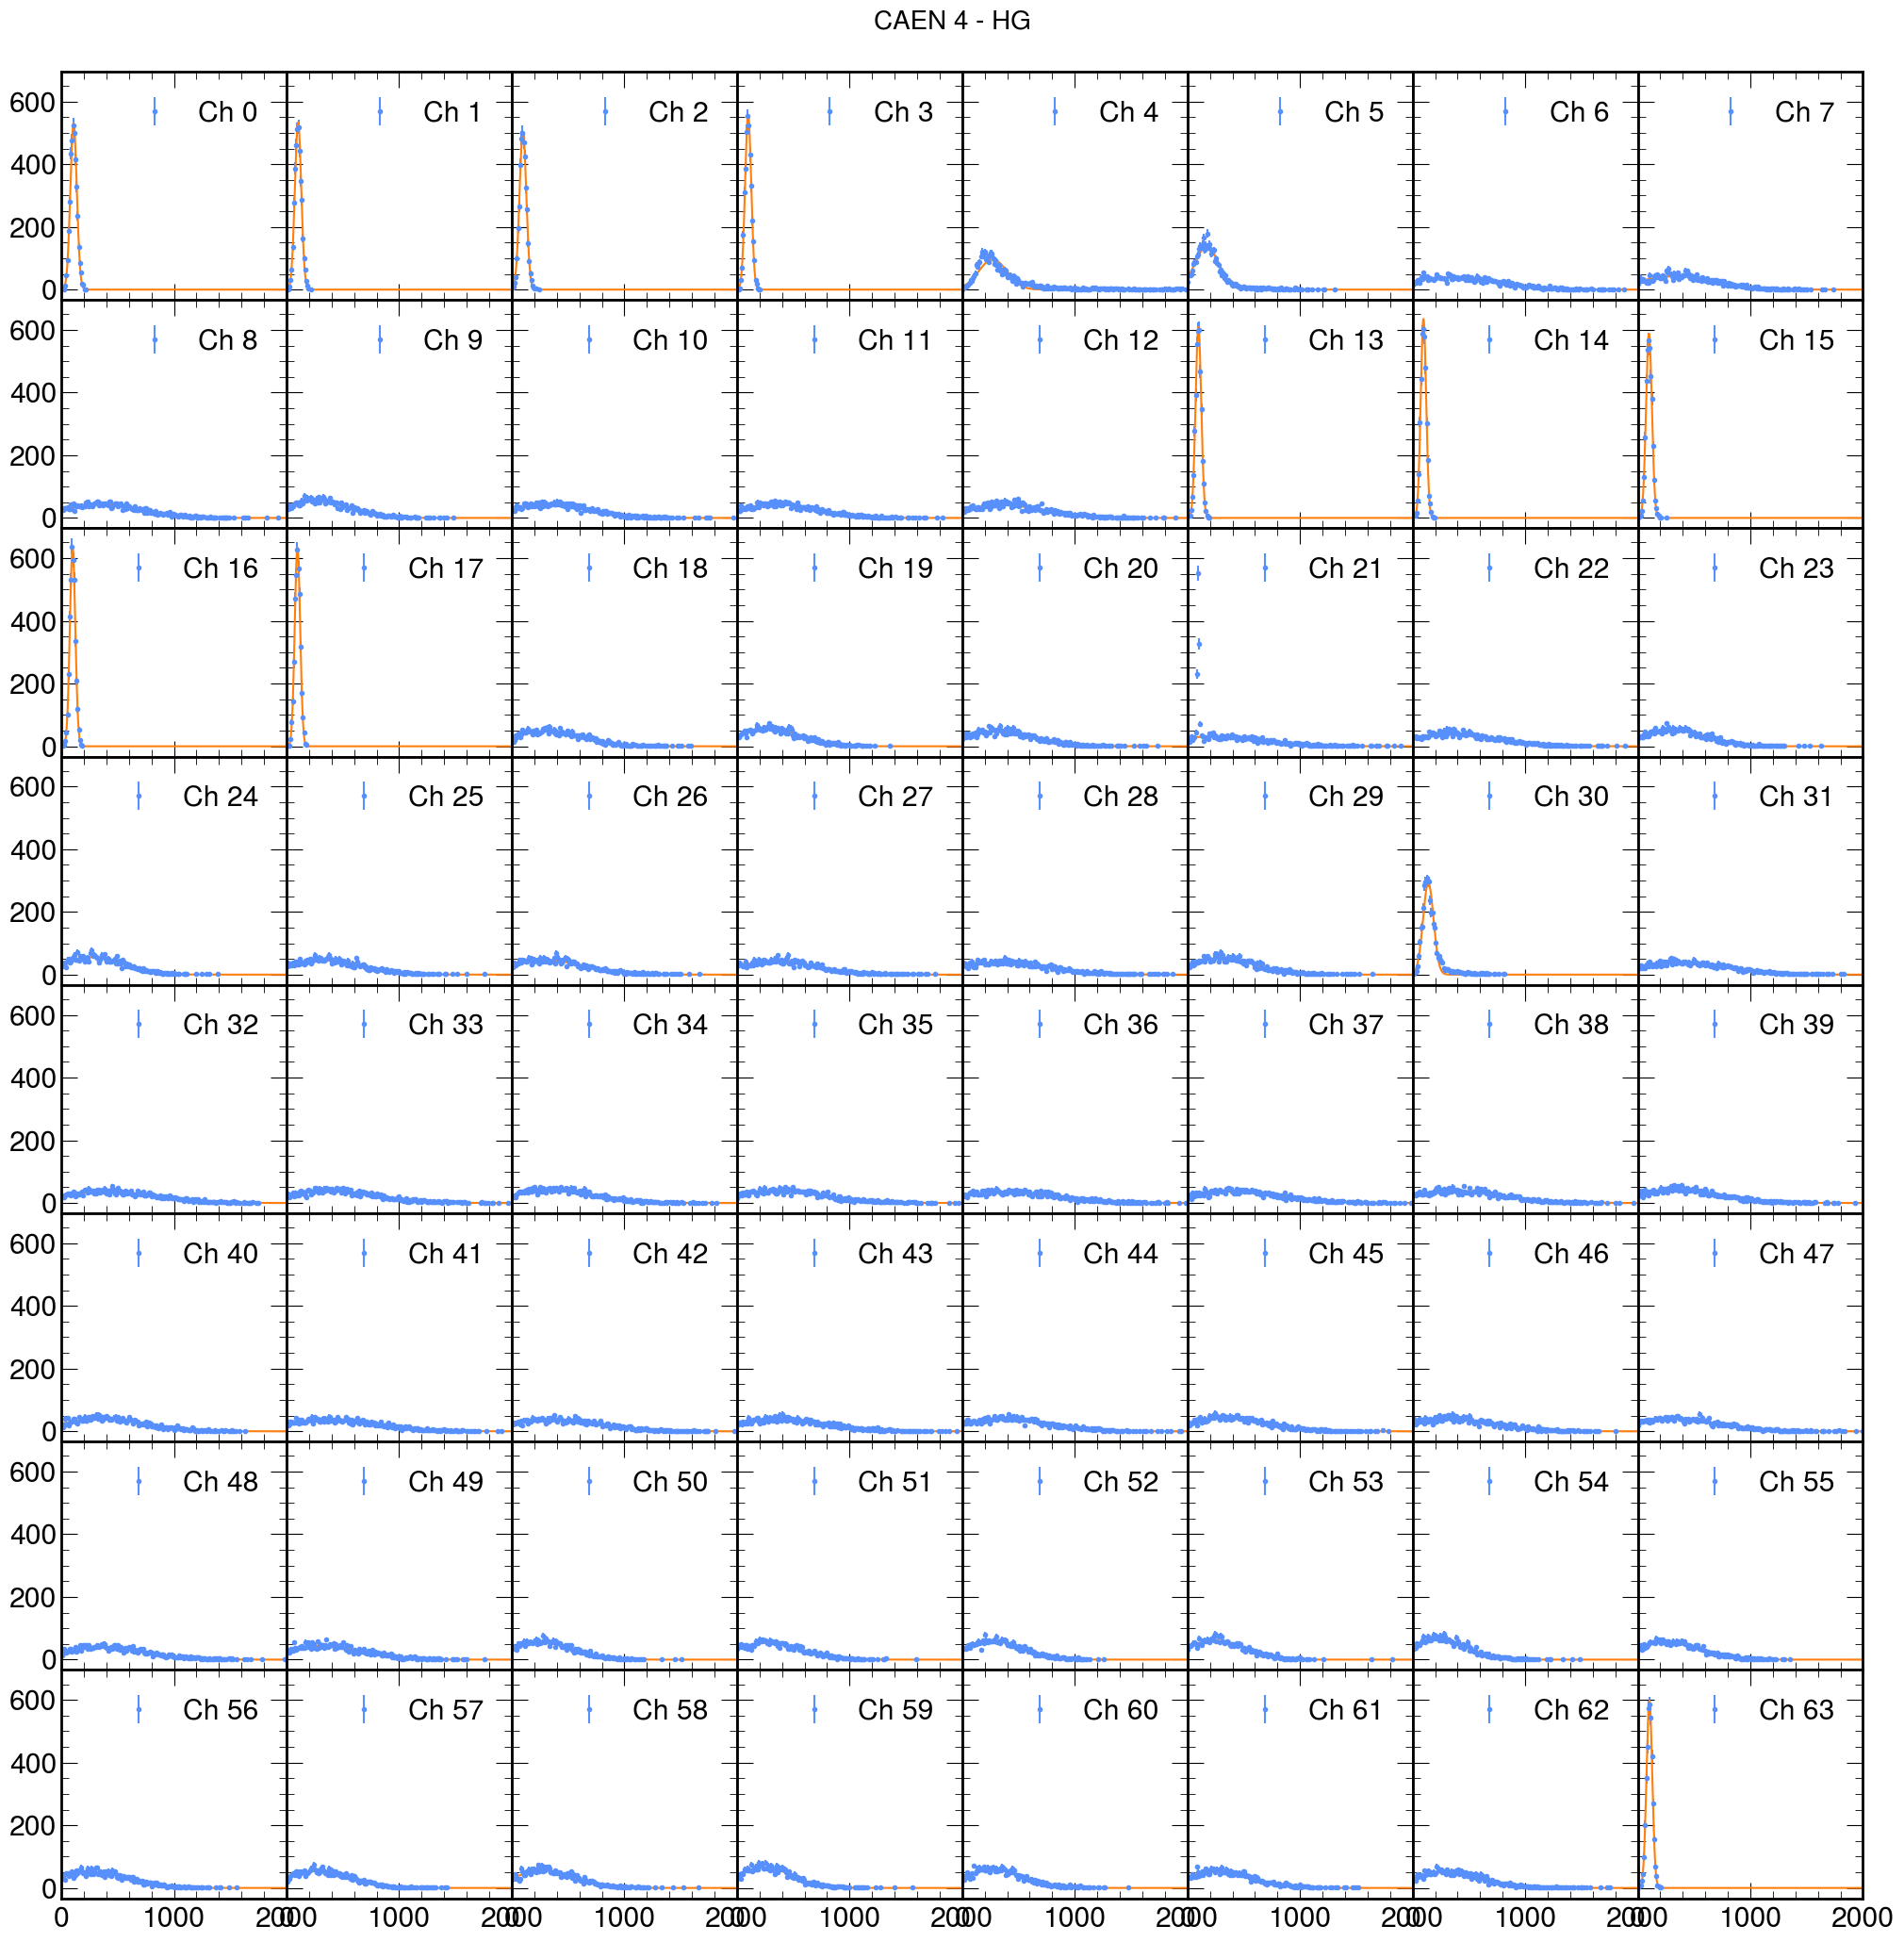

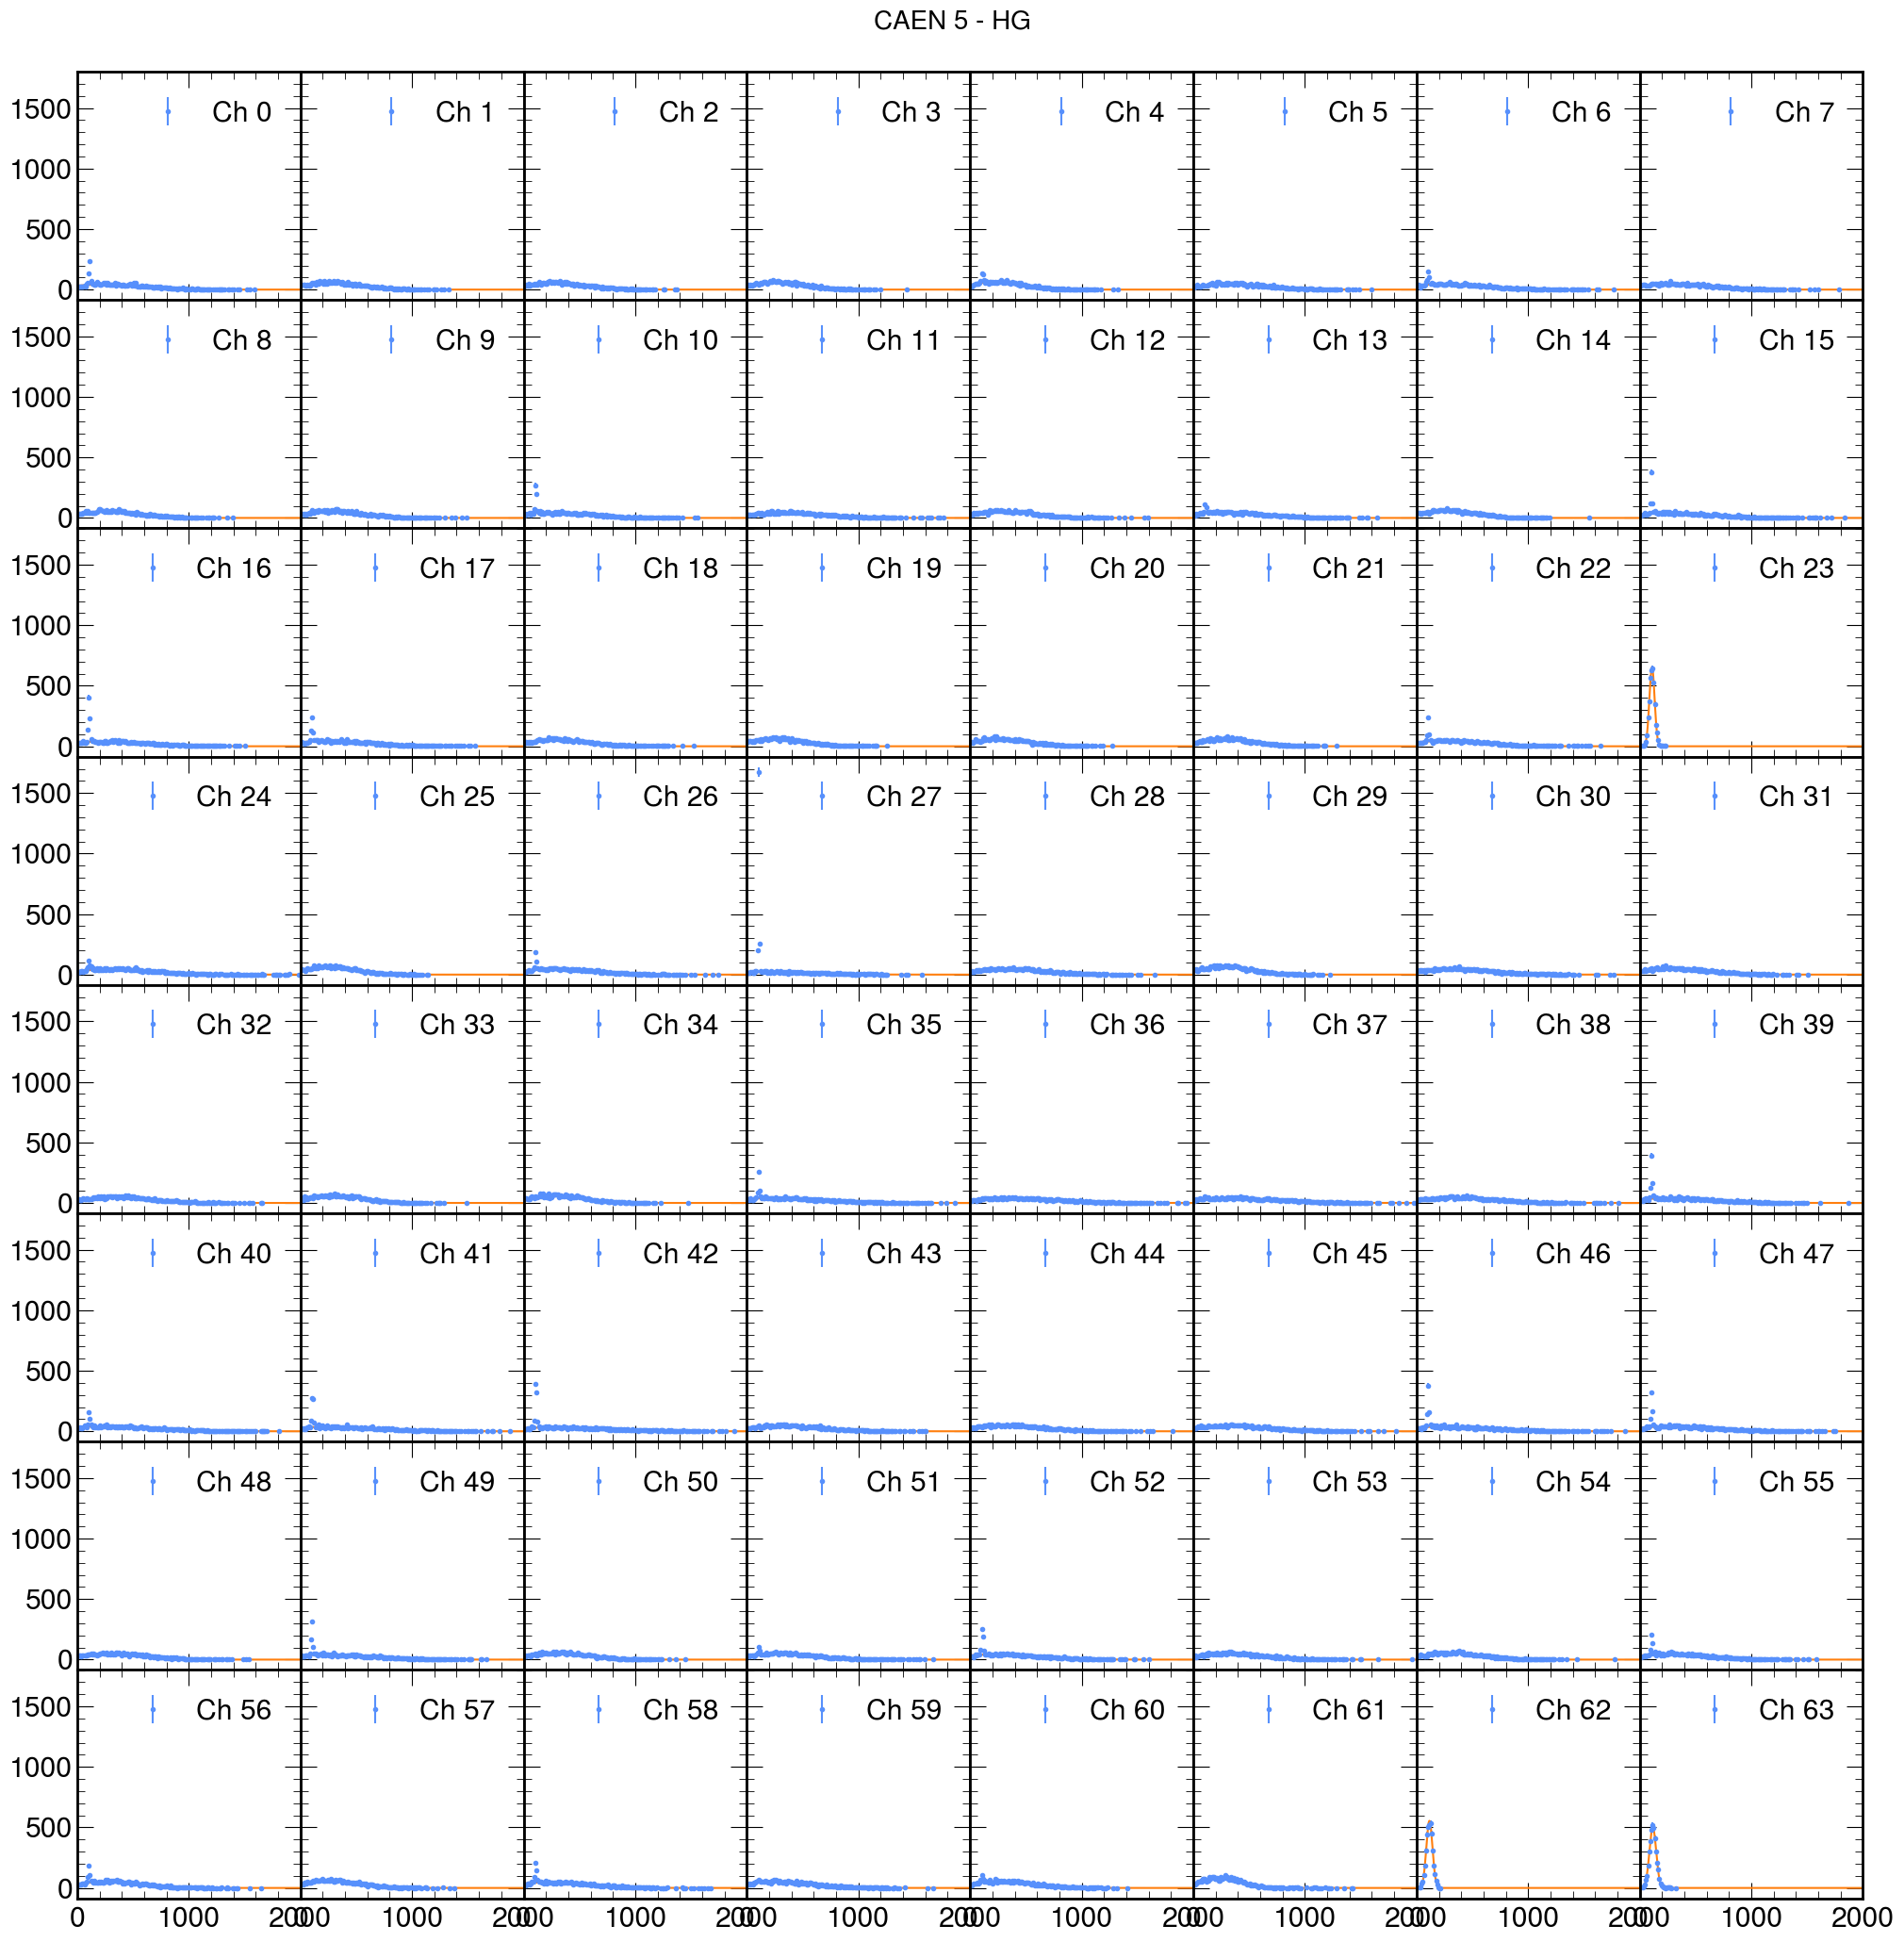

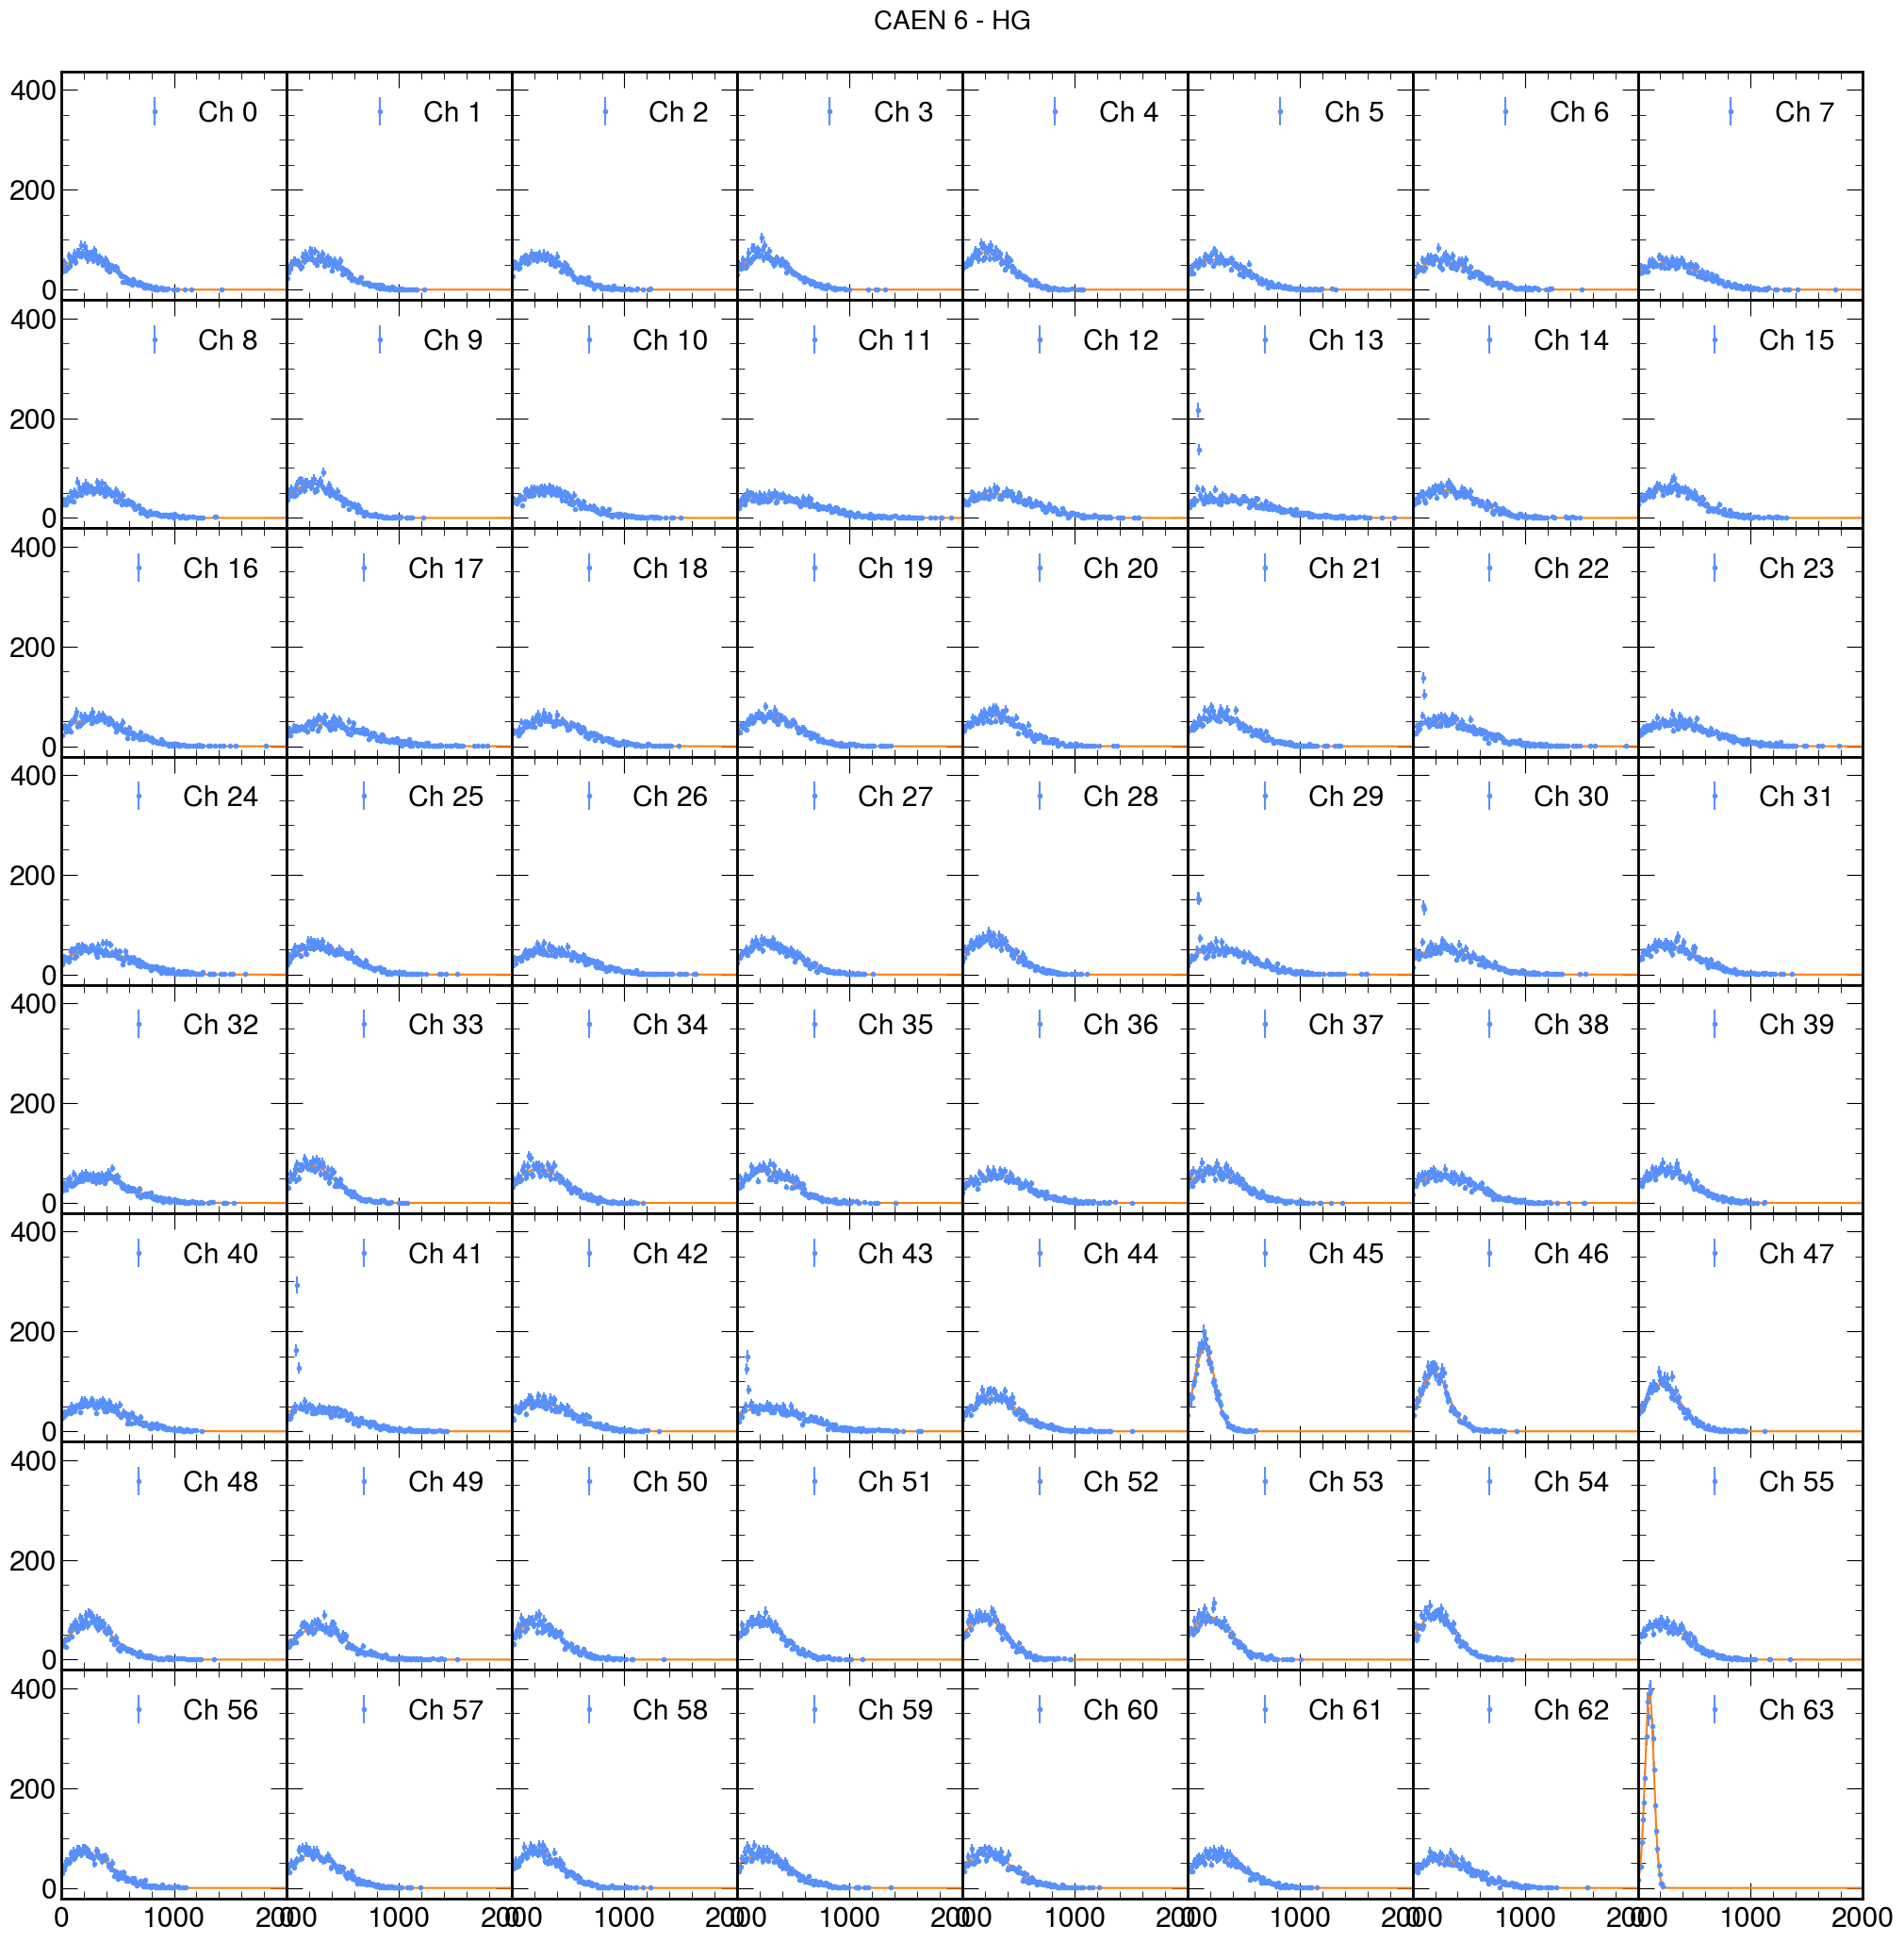

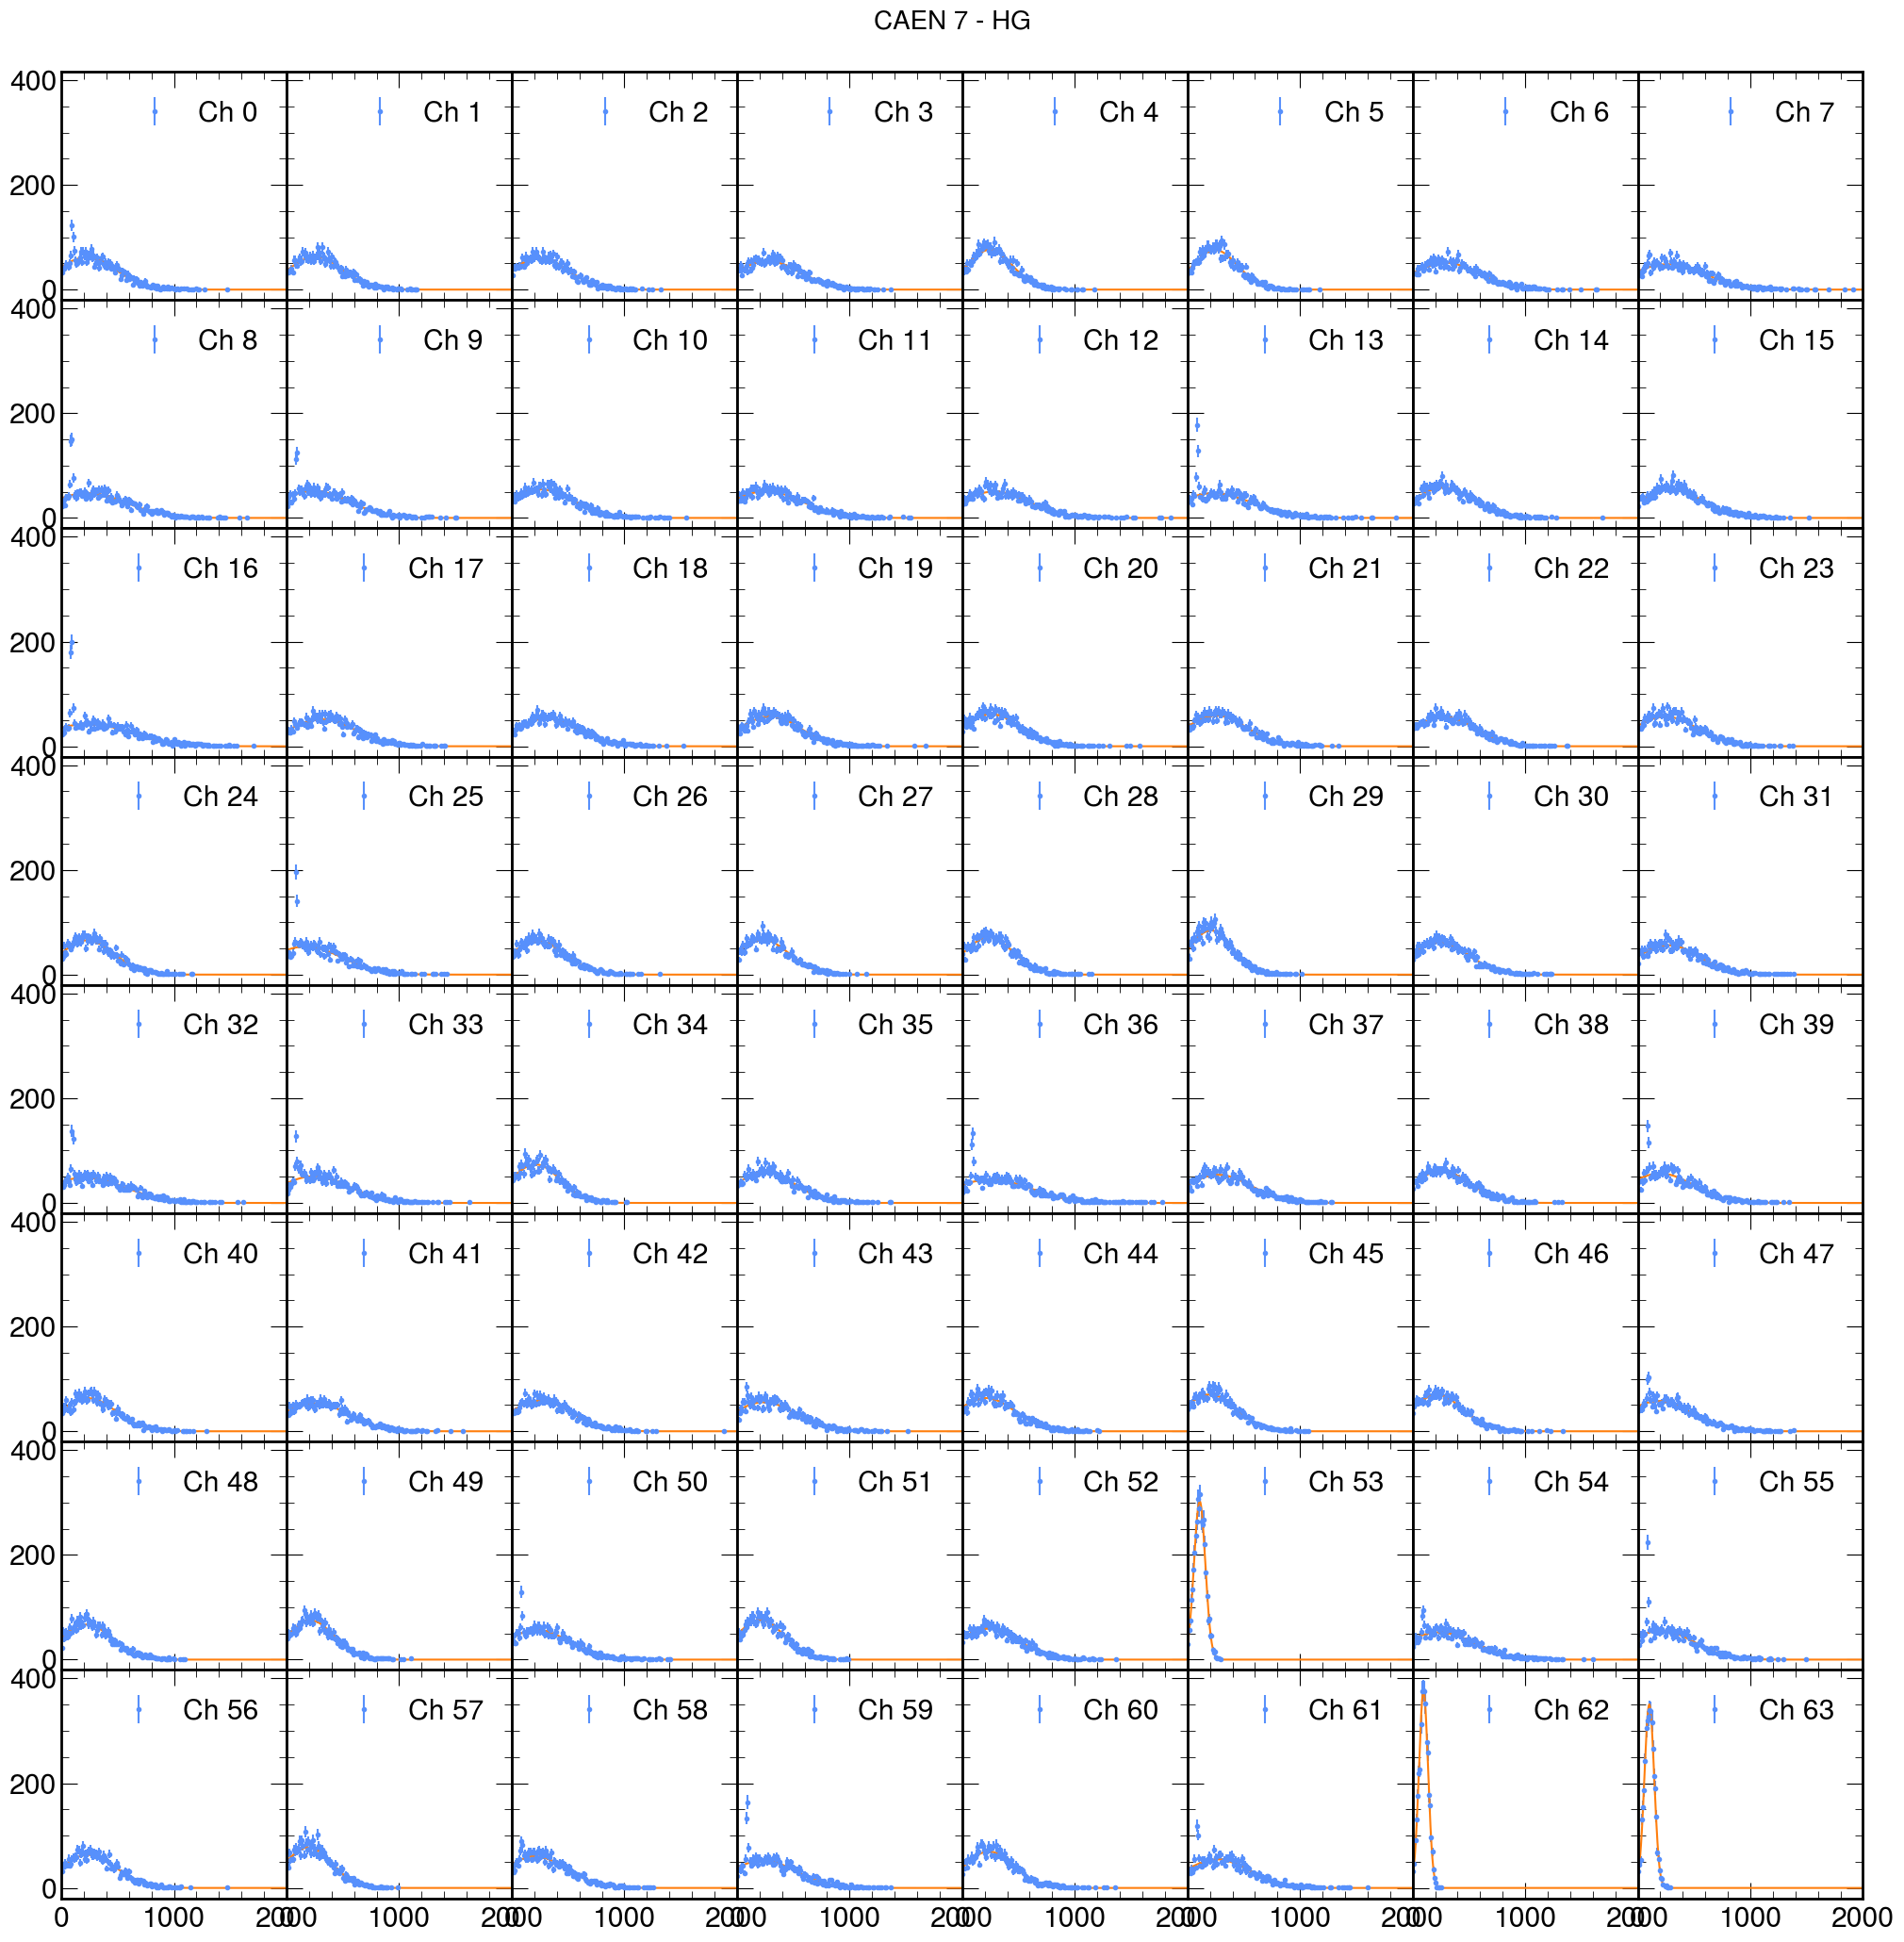

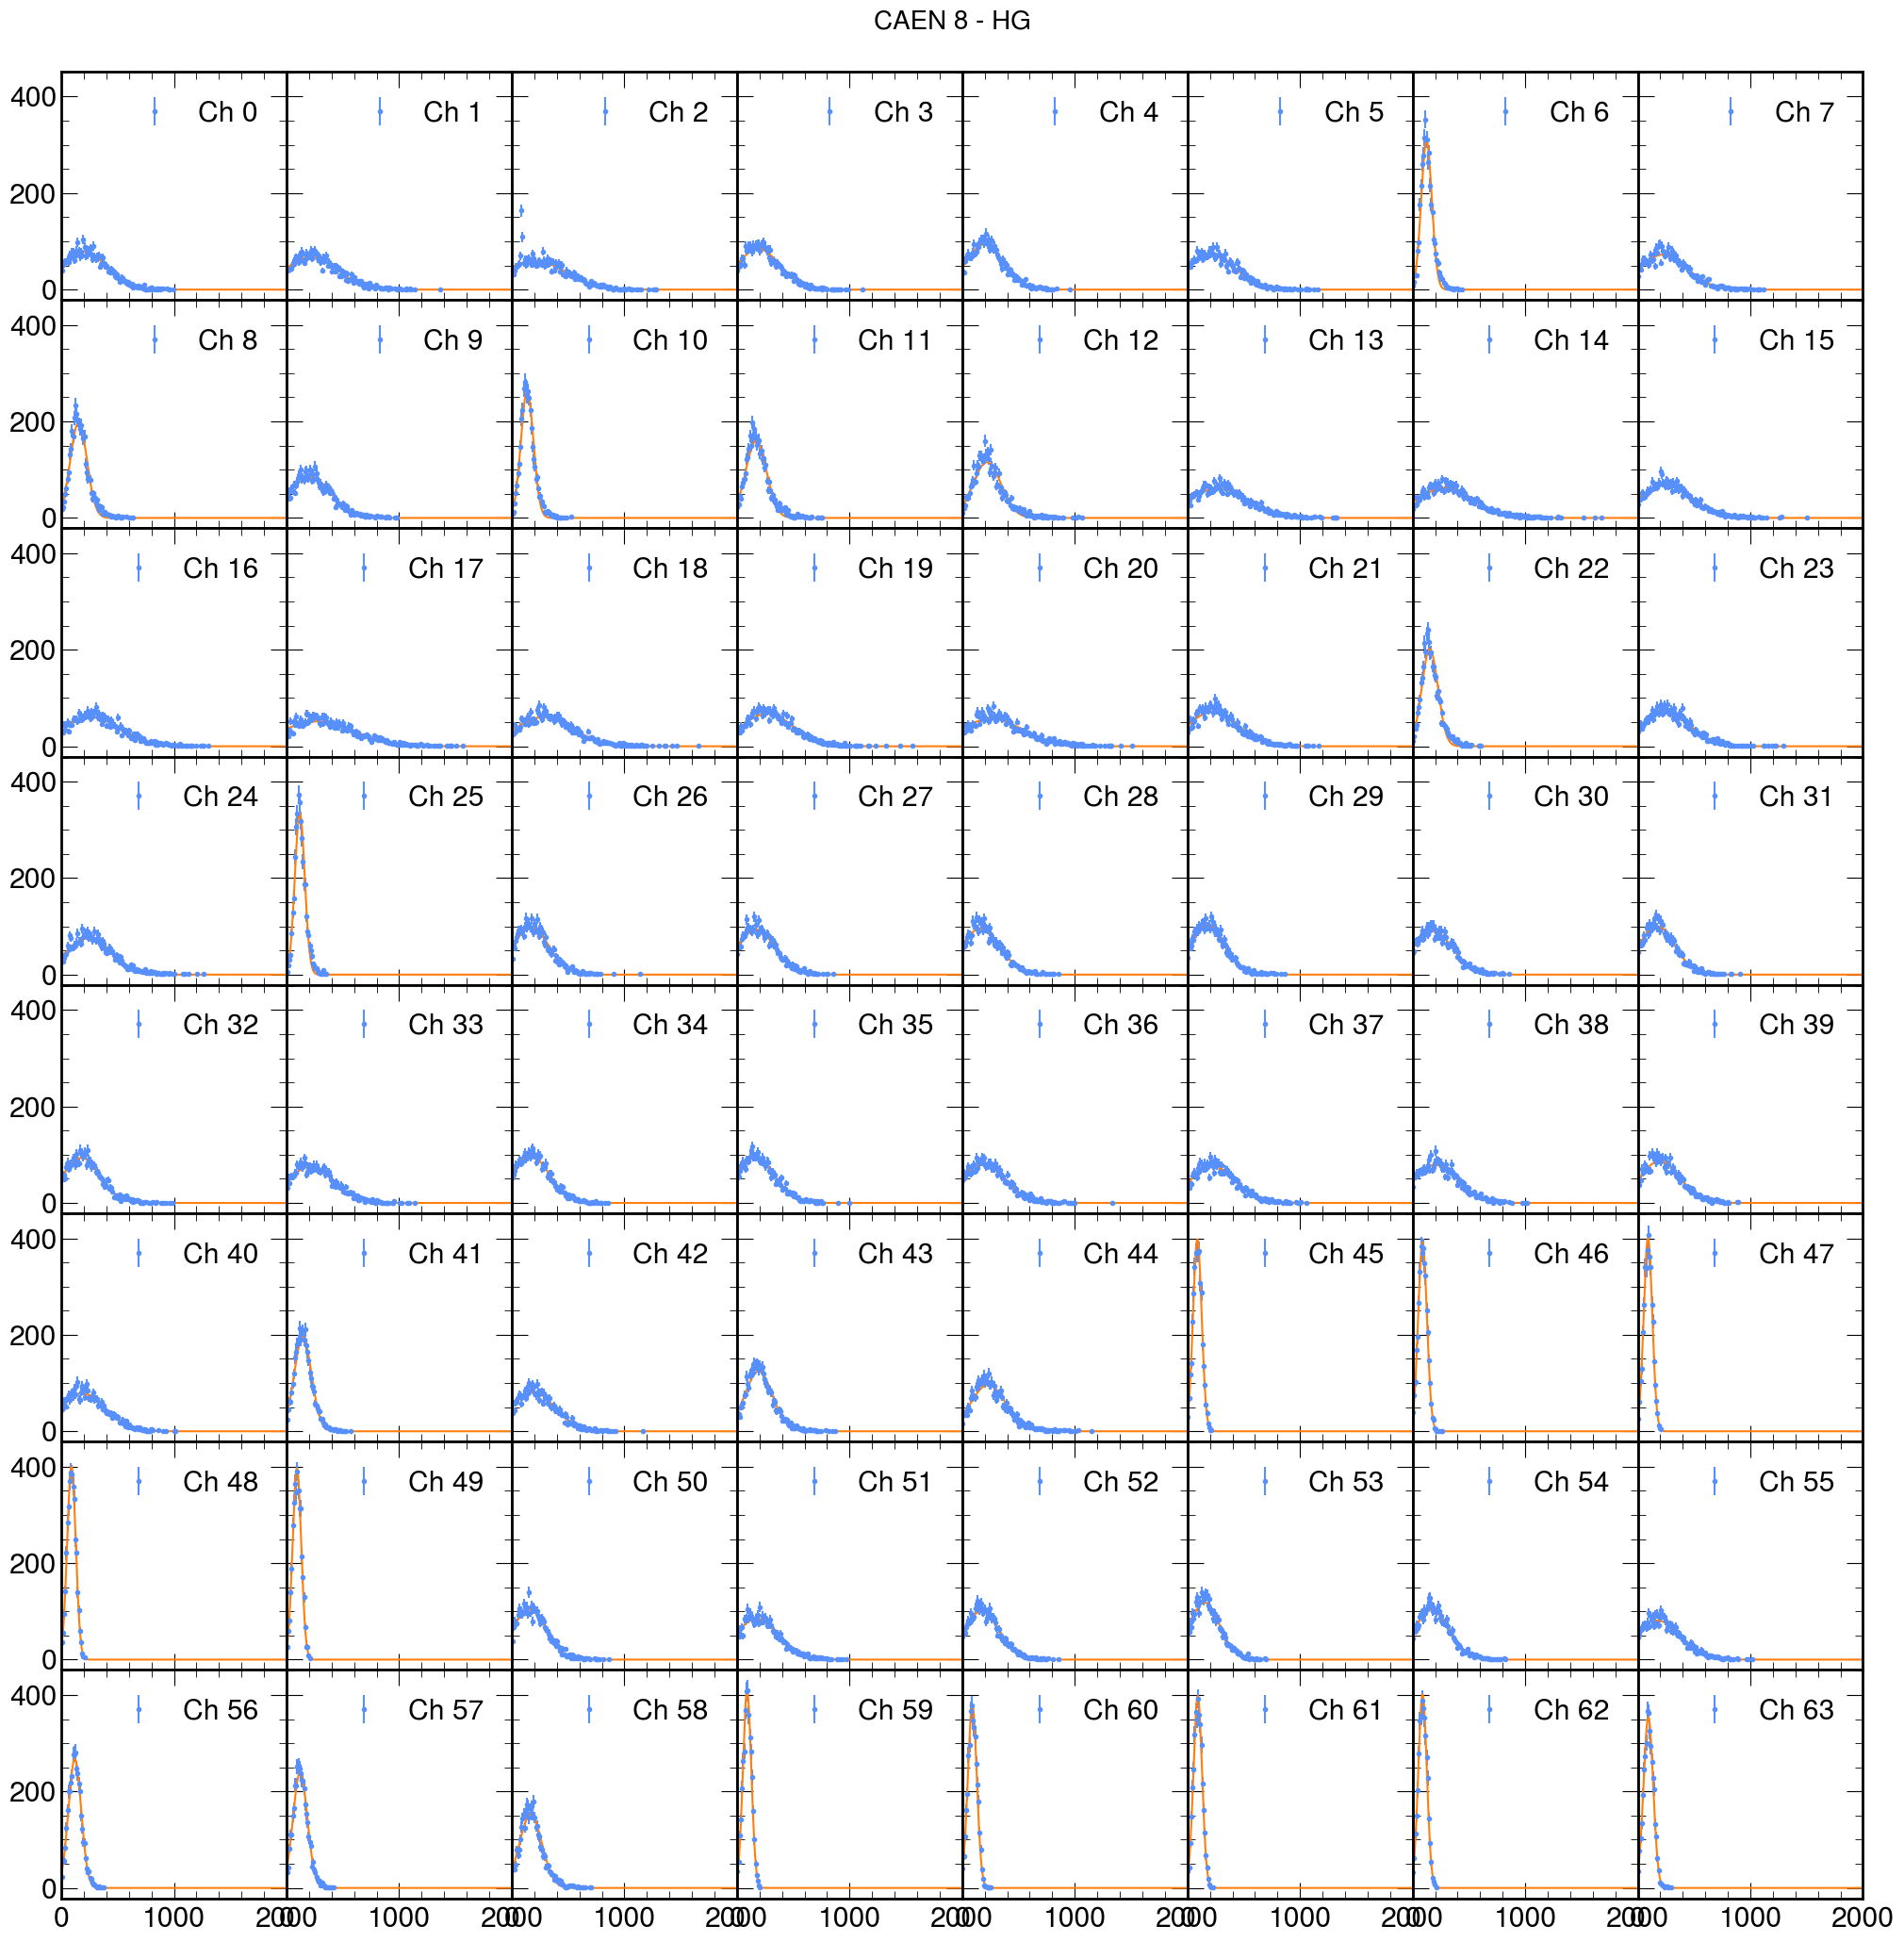

In [5]:
HGPeds, HGPedStd, HGPedsErr, HGPedStdErr = [], [], [], []
configure_plotting()
for i in range(9):
    plot_caen_histograms(data_DF, caen_unit=i, gain_type="HG", Peds=HGPeds, PedStds=HGPedStd, PedErrs=HGPedsErr, PedStdErrs=HGPedStdErr)

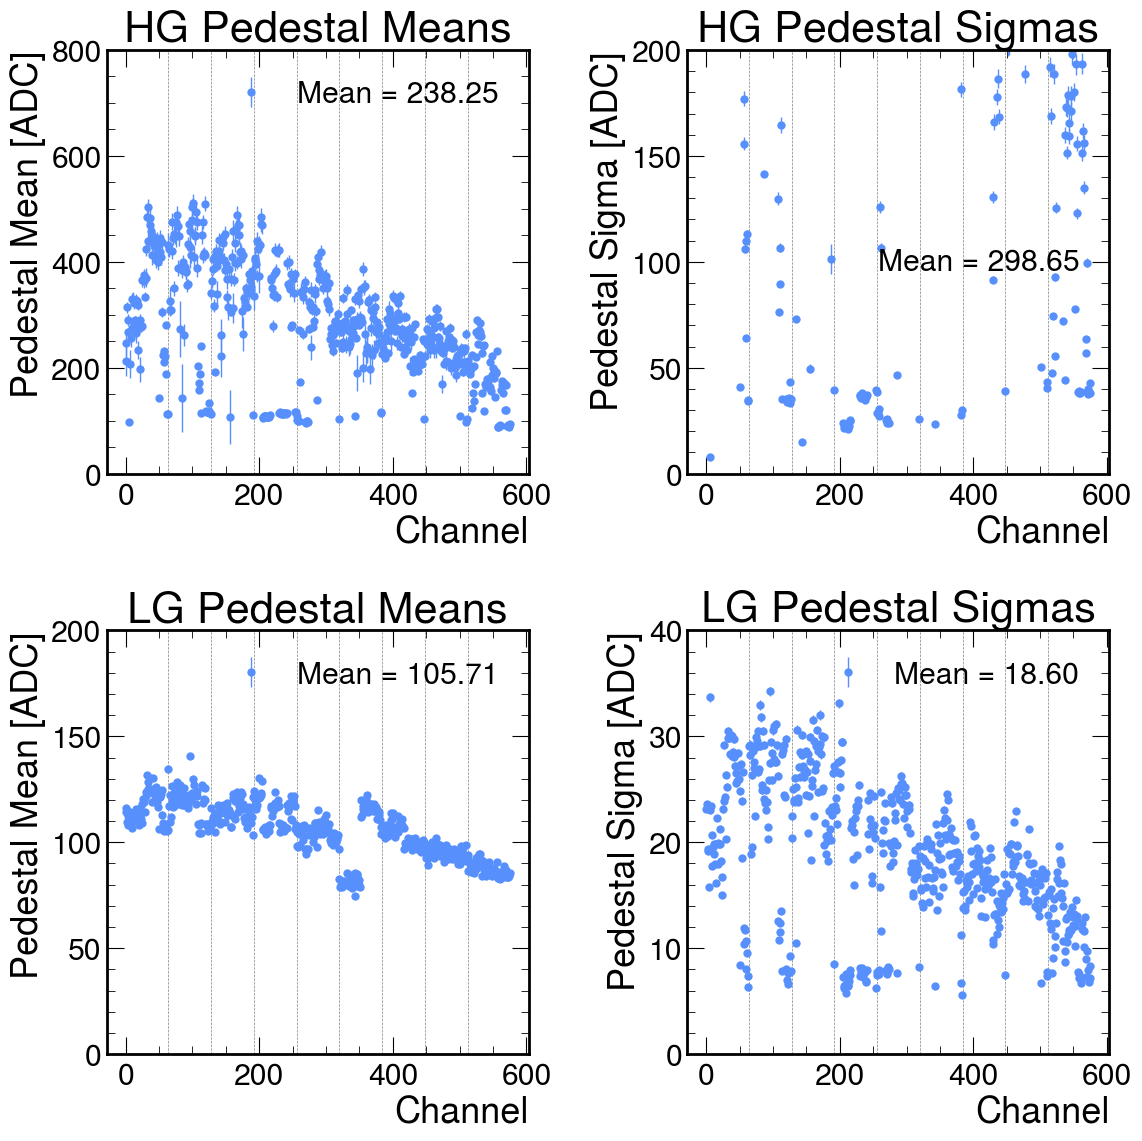

In [6]:
configure_plotting()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Create 2x2 grid of subplots
# Calculate max x-value based on the longest array
max_len = max(len(HGPeds), len(HGPedStd), len(LGPeds), len(LGPedStd))

# Add vertical lines at multiples of 64
for ax in axs.flat:
    for x in range(64, max_len, 64):
        ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
mean_val = np.mean(HGPeds)
axs[0, 0].errorbar(x=range(len(HGPeds)), y=HGPeds, yerr=HGPedsErr, fmt='o',
                   capsize=0, elinewidth=1, markeredgewidth=0,
                   label=f"Mean = {mean_val:.2f}")
axs[0, 0].set_ylim(0, 800)
axs[0, 0].set_title("HG Pedestal Means")
axs[0, 0].set_xlabel("Channel")
axs[0, 0].set_ylabel("Pedestal Mean [ADC]")
axs[0, 0].legend()

# Top right: HG Pedestal Sigmas
mean_val = np.mean(HGPedStd)
axs[0, 1].errorbar(x=range(len(HGPedStd)), y=HGPedStd, yerr=HGPedStdErr, fmt='o',
                   capsize=0, elinewidth=1, markeredgewidth=0,
                   label=f"Mean = {mean_val:.2f}")
axs[0, 1].set_ylim(0, 200)
axs[0, 1].set_title("HG Pedestal Sigmas")
axs[0, 1].set_xlabel("Channel")
axs[0, 1].set_ylabel("Pedestal Sigma [ADC]")
axs[0, 1].legend()

# Bottom left: LG Pedestal Means
mean_val = np.mean(LGPeds)
axs[1, 0].errorbar(x=range(len(LGPeds)), y=LGPeds, yerr=LGPedsErr, fmt='o',
                   capsize=0, elinewidth=1, markeredgewidth=0,
                   label=f"Mean = {mean_val:.2f}")
axs[1, 0].set_ylim(0, 200)
axs[1, 0].set_title("LG Pedestal Means")
axs[1, 0].set_xlabel("Channel")
axs[1, 0].set_ylabel("Pedestal Mean [ADC]")
axs[1, 0].legend()

# Bottom right: LG Pedestal Sigmas
mean_val = np.mean(LGPedStd)
axs[1, 1].errorbar(x=range(len(LGPedStd)), y=LGPedStd, yerr=LGPedStdErr, fmt='o',
                   capsize=0, elinewidth=1, markeredgewidth=0,
                   label=f"Mean = {mean_val:.2f}")
axs[1, 1].set_ylim(0, 40)
axs[1, 1].set_title("LG Pedestal Sigmas")
axs[1, 1].set_xlabel("Channel")
axs[1, 1].set_ylabel("Pedestal Sigma [ADC]")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

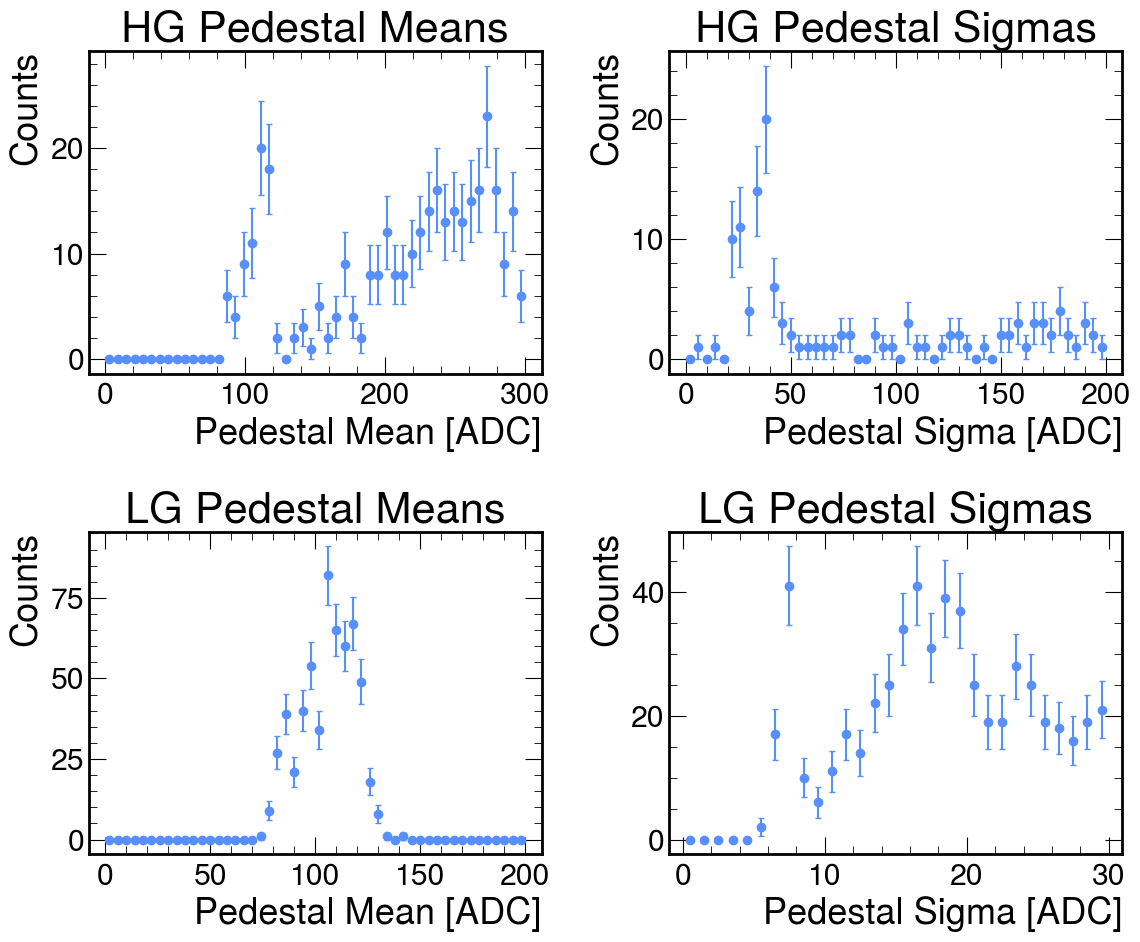

In [7]:
configure_plotting()

# Number of bins for histograms
num_bins = 30

# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top left: HG Pedestal Means Histogram
filtered = np.array(HGPeds)[np.array(HGPeds) > 0]
counts, bin_edges = np.histogram(filtered, bins=50, range=(0, 300))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
axs[0, 0].errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)
axs[0, 0].set_title("HG Pedestal Means")
axs[0, 0].set_xlabel("Pedestal Mean [ADC]")
axs[0, 0].set_ylabel("Counts")

# Top right: HG Pedestal Sigmas Histogram
filtered = np.array(HGPedStd)[np.array(HGPedStd) > 0]
counts, bin_edges = np.histogram(filtered, bins=50, range=(0, 200))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
axs[0, 1].errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)
axs[0, 1].set_title("HG Pedestal Sigmas")
axs[0, 1].set_xlabel("Pedestal Sigma [ADC]")
axs[0, 1].set_ylabel("Counts")

# Bottom left: LG Pedestal Means Histogram
filtered = np.array(LGPeds)[np.array(LGPeds) > 0]
counts, bin_edges = np.histogram(filtered, bins=50, range=(0, 200))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
axs[1, 0].errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)
axs[1, 0].set_title("LG Pedestal Means")
axs[1, 0].set_xlabel("Pedestal Mean [ADC]")
axs[1, 0].set_ylabel("Counts")

# Bottom right: LG Pedestal Sigmas Histogram
filtered = np.array(LGPedStd)[np.array(LGPedStd) > 0]
counts, bin_edges = np.histogram(filtered, bins=30, range=(0, 30))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
axs[1, 1].errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)
axs[1, 1].set_title("LG Pedestal Sigmas")
axs[1, 1].set_xlabel("Pedestal Sigma [ADC]")
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

In [8]:
num_channels = len(HGPeds)

# Compute CAEN and CAEN_ch for each channel
channels = np.arange(num_channels)
CAEN = channels // 64
CAEN_ch = channels % 64

# Build the DataFrame
pedestal_df = pd.DataFrame({
    'channel': channels,
    'CAEN': CAEN,
    'CAEN_ch': CAEN_ch,
    'HGPedMean': HGPeds,
    'HGPedSigma': HGPedStd,
    'LGPedMean': LGPeds,
    'LGPedSigma': LGPedStd
})


In [9]:
with open('Ped_BNL.pkl', 'wb') as f:
    pickle.dump(pedestal_df, f)